<a href="https://colab.research.google.com/github/kenza-benkirane/Learning/blob/main/COMP0188_CW2_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP0188 Coursework 2: Age Regression from Brain MRIs (30 Marks)


## 0. Introductions, importants and settings


### 0.1.Intro


MRI scans can be used to determine volumes of different types of brain tissue which are associated with age. In particular, as patients age, it is known that the ventricles enlarge (as they get filled with cerebrospinal fluid), while the volume of grey and white matter volume may decrease.

Your task is to develop a deep learning model capable of predicting the (biological) age of a patient from MRI scans. Such a tool could be used in clinical practice to compare a patients 'biological' age against their 'true' chronological age. A significant discrepency in these ages might indicate the presense of a disease in the patient.

You have been provided with a dataset of healthy patients. The dataset contains MRI scans of the patients, and their corresponing chronological ages (amongst other information). As the patients are healthy, we will assume that their biological and chronological ages are equal.

We have provided you with helper code, and have marked additional code you will need to implement with "🚧 **Exercise** 🚧". However, you are not bound to this code (i.e. you may modify it if you wish), or even this notebook - you may complete the coursework however you see fit.


**Notebook Overview**
The notebook is split into 3 parts:

- Part 1: Dataset analysis and defining a suitable setup (8 marks)
- Part 2: Baseline model definition (7 marks)
- Part 3: Improving upon the Baseline (15 marks)

Please see the introduction for each section for more information.


**Loading the Dataset and Running the Notebook**

Use Google Colab to run the notebook. Run the cells in sequence, as per usual.


**Requirements**

- SimpleITK
- wandb


**Dependancies**


In [ ]:
pip install SimpleITK

### 0.2.Imports


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# Added imports -> TO CHECK
from torchsummary import summary
from sklearn.metrics import r2_score, mean_squared_error
import random
from typing import List, Dict, Tuple, Literal
import pickle
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import seaborn as sns
import random
from ipywidgets import interact, fixed
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import gdown
import zipfile
import os
import psutil
from scipy.stats import norm
from scipy.stats import probplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available, using CPU.")


GPU is available.


In [ ]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"GPU is available. Number of GPUs: {num_gpus}")
else:
    print("GPU is not available, using CPU.")


GPU is available. Number of GPUs: 1


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 0.3. Global config


#### Option 1: Local zip file

In [ ]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [ ]:
# # Provide the path to the folder in your Google Drive
# data_dir = '/content/drive/MyDrive/AI4BH/comp0188/CW2/data'

# # Set the current working directory to the folder
# %cd $folder_path

#### Option 2: Provided zip file

In [ ]:
# Used for debugging the notebook locally. Leave as True when running in colab!
download = True

# Expect the download to take roughly 3 mins
if download:
    # Replace this with your Google Drive shared link or file ID
    google_drive_shared_link = 'https://drive.google.com/file/d/1QadZo1gSD4Wm4epct4ACQQFuyimFYbbO/view?usp=share_link'
    file_id = google_drive_shared_link.split('/')[-2]

    # Construct the gdown URL
    download_url = f'https://drive.google.com/uc?id={file_id}'

    # Path where the downloaded file will be stored
    output_path = 'download.zip'

    # Download the file from Google Drive
    gdown.download(download_url, output_path, quiet=False)

    # Unzip the file
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        zip_ref.extractall('data')

    # Optionally, delete the zip file after extraction
    # os.remove(output_path)

    data_dir = "data/coursework_1_compressed/coursework_1"
else:
    data_dir = "../../coursework_1_compressed/coursework_1" # "../../coursework_1/coursework_1"

Downloading...
From: https://drive.google.com/uc?id=1QadZo1gSD4Wm4epct4ACQQFuyimFYbbO
To: /content/download.zip
100%|██████████| 4.92G/4.92G [00:43<00:00, 112MB/s]


## Part 1: Dataset analysis and define a suitable setup

- Dataset analysis

It is important to analyse your dataset to better understand it and to help detect any issues in the dataset. This can be done via visualizations and calculating statistics from the available information.

- Defining a suitable setup

Before performing any kind of model development, it is critical to define the scope of the model development process. This includes making decisions which stay fixed throughout the rest of the model development; as changing them would render model comparisons invalid. For example, comparing two models with test score calculated on different test datasets or with different metrics is meaningless.

This section should help you answer following questions:

- How should the train/validation/test set be split?
- What metric will be used to assess model performance on the test set?
  - It is critical to consider the broader project metric when setting this. In this case the project metric is to "predict the patients biological age from MRI scans". Furthermore, we want to make sure that the model can predict age well for _all_ patients, not just a subset (which may happen if the input data is skewed, for example).

_Hint_:

- Consider the following kinds of analysis:
  - What relevant variables are available in the dataset? Do they need to be transformed?
  - What does the target variable look like?
  - Is the data sufficiently balanced?
  - What is the distribution of other variables?


In [ ]:
# Loading the data
MRI_TEMPLATE_FILE = os.path.join(
    data_dir, "quasiraw_space-MNI152_desc-brain_T1w.nii.gz"
)
## Loading the train data
TRAIN_DIR = os.path.join(data_dir, "train")
TRAIN_MRI_DIR = os.path.join(TRAIN_DIR, "quasiraw")
TRAIN_META_FILE = os.path.join(TRAIN_DIR, "participants.tsv")
## Loading the test data
TEST_DIR = os.path.join(data_dir, "test")
TEST_MRI_DIR = os.path.join(TEST_DIR, "quasiraw")
TEST_META_FILE = os.path.join(TEST_DIR, "participants.tsv")

# Define the imaging spacing
OUT_SPACING = [2, 2, 2]  # Pixel spacing in mm
OUT_SIZE = [96, 96, 96]  # Size of the output image

Dataset description:

- The data provided has already been split into a training and test dataset. Both the training and test data contain: (i) a file of images in the form of numpy arrays (the MRIs); (ii) a tab seperated file called "participants.tsv" which contains structured data for each patient (including the overall target of interest "age").
- The "participant_id" column defines a unique ID for each patient and can be used to link the structured data with the MRI scans. In particular, the patient with participant_id = "100053248969" has an associated MRI scan in the file "sub-100053248969_preproc-quasiraw_T1w.npy"

The code below provides some helper functions for to import the relevant data for analysis


In [ ]:
num_vars = [
    "age",
    "tiv",
    "csfv",
    "gmv",
    "wmv",
    "magnetic_field_strength",
    "acquisition_setting",
]

# Load the training data
train_meta_df = pd.read_csv(TRAIN_META_FILE, delimiter="\t", dtype=str)
train_meta_df[num_vars] = train_meta_df[num_vars].astype(float)
train_meta_df["age_round"] = np.round(train_meta_df["age"], 0).astype(int)
print(train_meta_df.shape)

bins = list(range(0, 80, 10))
bins.append(110)
train_meta_df["age_10_yr_bckt_bg_70"] = pd.cut(train_meta_df["age"], bins=bins)
print(train_meta_df["age_10_yr_bckt_bg_70"].value_counts())
train_meta_df["age_10_yr_bckt"] = pd.cut(train_meta_df["age"], bins=range(0, 110, 10))
print(train_meta_df["age_10_yr_bckt"].value_counts())

# Also load the test data - BUT DON'T LOOK AT IT!
test_meta_df = pd.read_csv(TEST_META_FILE, delimiter="\t", dtype=str)
test_meta_df[num_vars] = test_meta_df[num_vars].astype(float)
test_meta_df["age_round"] = np.round(train_meta_df["age"], 0).astype(int)
print(test_meta_df.shape)

test_meta_df["age_10_yr_bckt_bg_70"] = pd.cut(test_meta_df["age"], bins=bins)
print(test_meta_df["age_10_yr_bckt_bg_70"].value_counts())
test_meta_df["age_10_yr_bckt"] = pd.cut(test_meta_df["age"], bins=range(0, 110, 10))
print(test_meta_df["age_10_yr_bckt"].value_counts())

train_meta_df.head()

(466, 13)
(20, 30]     220
(10, 20]     152
(30, 40]      24
(0, 10]       21
(60, 70]      18
(40, 50]      14
(50, 60]       9
(70, 110]      8
Name: age_10_yr_bckt_bg_70, dtype: int64
(20, 30]     220
(10, 20]     152
(30, 40]      24
(0, 10]       21
(60, 70]      18
(40, 50]      14
(50, 60]       9
(70, 80]       8
(80, 90]       0
(90, 100]      0
Name: age_10_yr_bckt, dtype: int64
(167, 14)
(20, 30]     84
(10, 20]     53
(0, 10]      10
(30, 40]      9
(40, 50]      4
(60, 70]      4
(50, 60]      2
(70, 110]     1
Name: age_10_yr_bckt_bg_70, dtype: int64
(20, 30]     84
(10, 20]     53
(0, 10]      10
(30, 40]      9
(40, 50]      4
(60, 70]      4
(50, 60]      2
(70, 80]      1
(80, 90]      0
(90, 100]     0
Name: age_10_yr_bckt, dtype: int64


,participant_id,study,sex,age,site,diagnosis,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,age_round,age_10_yr_bckt_bg_70,age_10_yr_bckt
0,100053248969,8,female,19.0,48.0,control,1434.357361,219.565569,678.230161,535.878459,3.0,1.0,19,"(10, 20]","(10, 20]"
1,100263562592,4,male,21.0,3.0,control,1558.161428,261.968669,756.742506,538.817738,3.0,1.0,21,"(20, 30]","(20, 30]"
2,100479214233,2,female,21.0,29.0,control,1418.050690,242.123816,686.814910,488.740580,3.0,1.0,21,"(20, 30]","(20, 30]"
3,100544064116,3,female,15.0,65.0,control,1304.233543,206.305238,667.809720,429.723510,3.0,1.0,15,"(10, 20]","(10, 20]"
4,101404752059,4,male,31.0,3.0,control,1660.856147,344.783456,703.484560,611.222413,3.0,1.0,31,"(30, 40]","(30, 40]"


Descriptions for relevant (non-self-descriptive) column names:

- **participant_id:** Unique ID for each patient, can be used to link to the MRI scans.
- **csfv:** Cerebrospinalfluid volume
- **gmv:** Grey matter volume
- **wmv:** White matter volume


In [ ]:
def load_patient_mri_array(patient_id: str, mri_dir: str) -> np.array:
    """Function to load a patient .nii.gz file containing an MRI 3D scan into a
    numpy array

    Args:
        patient_id (str): Patient ID string
        mri_dir (str): String representing the directory containing the MRI
        .nii.gz files

    Returns:
        np.array: 3D numpy array representing the MRI scan
    """
    mri_file = f"nifti/sub-{patient_id}_preproc-quasiraw_T1w.nii.gz"
    img_array = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(mri_dir, mri_file)))
    return np.expand_dims(img_array, axis=0)


In [ ]:
def vis_raw_mri_image(
    img_array: np.array,
    x: int = None,
    y: int = None,
    z: int = None,
    crosshair: bool = False,
    template_file: str = MRI_TEMPLATE_FILE,
):
    """Function to display orthogonal 2D slices of the 3D MRI image

    Args:
        img_array (np.array): 3D numpy array representing the MRI scan
        x (int, optional): x slice co-ordinate. Defaults to None.
        y (int, optional): y slice co-ordinate. Defaults to None.
        z (int, optional): z slice co-ordinate. Defaults to None.
        crosshair (bool, optional): Flag that determines whether the images
        should be shown with x/y lines across the centres of the axes.
        Defaults to False.
        template_file (str, optional): String representing the MRI template file
        to extract the image dimensions. Defaults to MRI_TEMPLATE_FILE.
    """
    template = sitk.ReadImage(template_file)
    size = template.GetSize()
    spacing = template.GetSpacing()
    width = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth = size[2] * spacing[2]

    if x is None:
        x = np.floor(size[0] / 2).astype(
            int
        )  # The floor function rounds the result down to the nearest integer. It returns a floating-point value.
        # astype(int): This converts the floating-point result to an integer. It essentially truncates the decimal part, providing an integer result.
    if y is None:
        y = np.floor(size[1] / 2).astype(int)
    if z is None:
        z = np.floor(size[2] / 2).astype(int)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z, :, :], extent=(0, width, height, 0))
    ax2.imshow(img_array[:, y, :], origin="lower", extent=(0, width, 0, depth))
    ax3.imshow(img_array[:, :, x], origin="lower", extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()


Let's use the helper functions above to visualise the MRI scans for patient "100053248969"


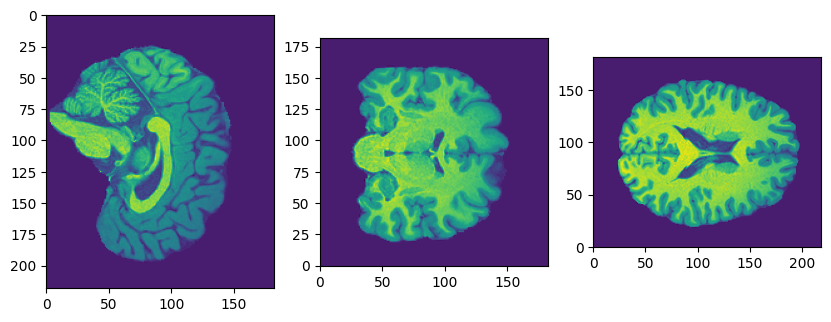

(1, 182, 218, 182)

In [ ]:
# Example with patient 100053248969
img_array = load_patient_mri_array("100053248969", mri_dir=TRAIN_MRI_DIR)
vis_raw_mri_image(img_array.squeeze())
display(img_array.shape)

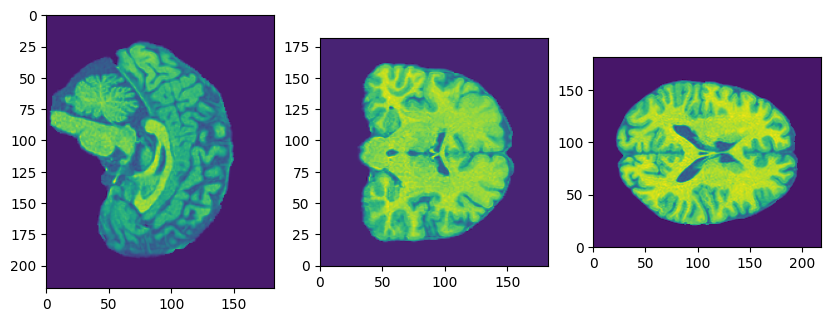

In [ ]:
# Example with a random patient
random_patient_id = random.choice(
    train_meta_df["participant_id"]
)  # Get a random patient ID from the training set
random_patient_mri = load_patient_mri_array(
    random_patient_id, mri_dir=TRAIN_MRI_DIR
)  # Load the MRI array for the random patient
vis_raw_mri_image(random_patient_mri.squeeze())  # Visualize the MRI images

🚧 **Exercise 1.1** 🚧

Below, perform any data analysis / data visualizations you think will be useful. These may help you better understand the distribution and demographics of the dataset.


In [ ]:
####################
# Insert code here #
####################

In [ ]:
df = train_meta_df.copy()

##### 1/ Dataset analysis


In [ ]:
df.head().style.background_gradient(cmap="Blues")

,participant_id,study,sex,age,site,diagnosis,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,age_round,age_10_yr_bckt_bg_70,age_10_yr_bckt
0,100053248969,8,female,19.000000,48.0,control,1434.357361,219.565569,678.230161,535.878459,3.000000,1.000000,19,"(10, 20]","(10, 20]"
1,100263562592,4,male,21.000000,3.0,control,1558.161428,261.968669,756.742506,538.817738,3.000000,1.000000,21,"(20, 30]","(20, 30]"
2,100479214233,2,female,21.000000,29.0,control,1418.050690,242.123816,686.814910,488.740580,3.000000,1.000000,21,"(20, 30]","(20, 30]"
3,100544064116,3,female,15.000000,65.0,control,1304.233543,206.305238,667.809720,429.723510,3.000000,1.000000,15,"(10, 20]","(10, 20]"
4,101404752059,4,male,31.000000,3.0,control,1660.856147,344.783456,703.484560,611.222413,3.000000,1.000000,31,"(30, 40]","(30, 40]"


In [ ]:
# Data analysis
## Statistics
df.describe()


,age,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,age_round
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,24.730252,1456.635720,253.442490,688.582493,513.718637,2.929185,1.236052,24.736052
std,13.336105,152.716391,58.583505,88.890556,65.538662,0.318474,0.536885,13.353469
min,6.685832,872.171976,132.658013,318.006349,366.674730,1.500000,1.000000,7.000000
25%,19.000000,1353.494430,212.481464,632.668129,466.900321,3.000000,1.000000,19.000000
50%,21.000000,1455.430354,243.069997,685.587609,508.899812,3.000000,1.000000,21.000000
75%,26.963200,1556.756432,282.458288,744.194179,553.858052,3.000000,1.000000,27.000000
max,78.584531,1883.621349,488.987090,910.051941,731.075008,3.000000,3.000000,79.000000


In [ ]:
# auxiliary functions
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    # print("##################### Head #####################")
    # print(dataframe.head(3))
    # print("##################### Tail #####################")
    # print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())  # same as
    print("##################### Null values #####################")
    print(dataframe.eq(0).sum())


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (
        dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100
    ).sort_values(ascending=False)
    missing_df = pd.concat(
        [n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"]
    )
    print(missing_df, end="\n")
    if na_name:
        return na_columns


missing_data = df.isnull().sum() / len(df) * 100  # Percentage of Data that are missing


def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(
            pd.DataFrame(
                {
                    "TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                    "Count": temp_df.groupby(col)[target].count(),
                }
            ),
            end="\n\n\n",
        )


check_df(df)


##################### Shape #####################
(466, 15)
##################### Types #####################
participant_id               object
study                        object
sex                          object
age                         float64
site                         object
diagnosis                    object
tiv                         float64
csfv                        float64
gmv                         float64
wmv                         float64
magnetic_field_strength     float64
acquisition_setting         float64
age_round                     int64
age_10_yr_bckt_bg_70       category
age_10_yr_bckt             category
dtype: object
##################### NA #####################
participant_id             0
study                      0
sex                        0
age                        0
site                       0
diagnosis                  0
tiv                        0
csfv                       0
gmv                        0
wmv                        0

In [ ]:
# Unique values per feature
print(len(df))
for i in list(df.columns):
    print(
        "Number of Unique values in {} :  {} ".format(i, df[i].value_counts().shape[0])
    )


466
Number of Unique values in participant_id :  466 
Number of Unique values in study :  10 
Number of Unique values in sex :  2 
Number of Unique values in age :  160 
Number of Unique values in site :  55 
Number of Unique values in diagnosis :  1 
Number of Unique values in tiv :  466 
Number of Unique values in csfv :  466 
Number of Unique values in gmv :  466 
Number of Unique values in wmv :  466 
Number of Unique values in magnetic_field_strength :  2 
Number of Unique values in acquisition_setting :  3 
Number of Unique values in age_round :  59 
Number of Unique values in age_10_yr_bckt_bg_70 :  8 
Number of Unique values in age_10_yr_bckt :  10 


In [ ]:
# Deleting useless columns
columns_to_drop = ["diagnosis"]
for col in columns_to_drop:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)


In [ ]:
# Separating columns as categorical and numerical
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    ------
        dataframe: dataframe

        cat_th: int, optional

        car_th: int, optinal
    Returns
    ------
        cat_cols: list
                Categorical features
        num_cols: list
                Numerical features
        cat_but_car: list
               Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [
        col
        for col in dataframe.columns
        if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"
    ]
    cat_but_car = [
        col
        for col in dataframe.columns
        if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"
    ]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car, num_but_cat


cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)


Observations: 466
Variables: 14
cat_cols: 6
num_cols: 6
cat_but_car: 2
num_but_cat: 4


In [ ]:
# Types of columns
print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)
print("Categorical but cardinal columns:", cat_but_car)
print("Numerical but categorical columns:", num_but_cat)

# New df for analysis
df_Num = df[num_cols]
df_Cat = df[cat_cols]
df_CatButCar = df[cat_but_car]


Numerical columns: ['age', 'tiv', 'csfv', 'gmv', 'wmv', 'age_round']
Categorical columns: ['study', 'sex', 'magnetic_field_strength', 'acquisition_setting', 'age_10_yr_bckt_bg_70', 'age_10_yr_bckt']
Categorical but cardinal columns: ['participant_id', 'site']
Numerical but categorical columns: ['magnetic_field_strength', 'acquisition_setting', 'age_10_yr_bckt_bg_70', 'age_10_yr_bckt']


##### 2/ Univariate data analysis and visualisation



 mu = 24.73 and sigma = 13.32



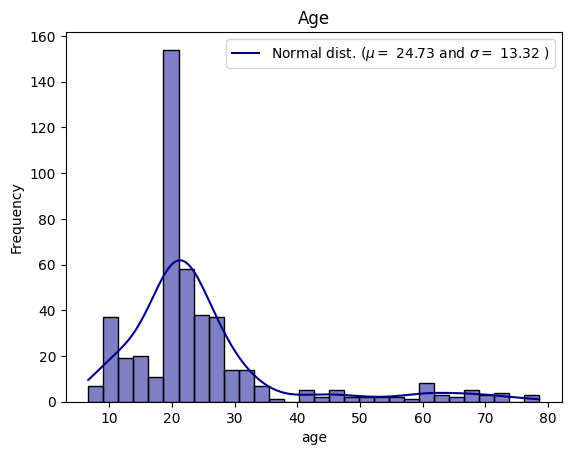

In [ ]:
# Histogram and normal fitting of the target column
sns.histplot(data=df_Num["age"], color="darkblue", kde=True, bins=30)
(mu, sigma) = norm.fit(df_Num["age"])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))
plt.legend(
    ["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)], loc="best"
)
plt.ylabel("Frequency")
plt.title("Age")
plt.show()


In [ ]:
# Assessing the representation of the below 40 patients in the dataset
over_40_df = df[(df["age"] <= 40)]
percentage_within_range = (len(over_40_df) / len(df)) * 100
print(
    f"The percentage of the dataset with age below 40 is: {percentage_within_range:.2f}%"
)


The percentage of the dataset with age below 40 is: 89.48%


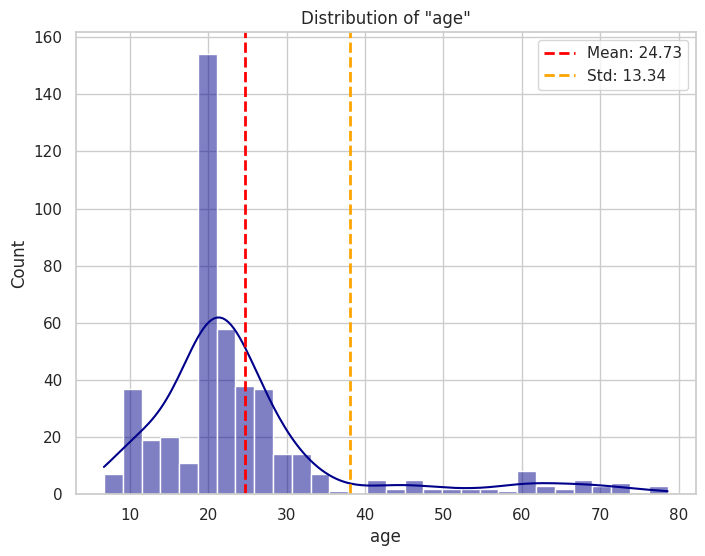

In [ ]:
# Histograms of the target column, including mean and std
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=df["age"], color="darkblue", kde=True, bins=30, ax=ax)
mean_val = df["age"].mean()
std_val = df["age"].std()

ax.axvline(
    mean_val,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Mean: {mean_val:.2f}",
)
ax.axvline(
    mean_val + std_val,
    color="orange",
    linestyle="dashed",
    linewidth=2,
    label=f"Std: {std_val:.2f}",
)

plt.title('Distribution of "age"')
plt.legend()

plt.show()


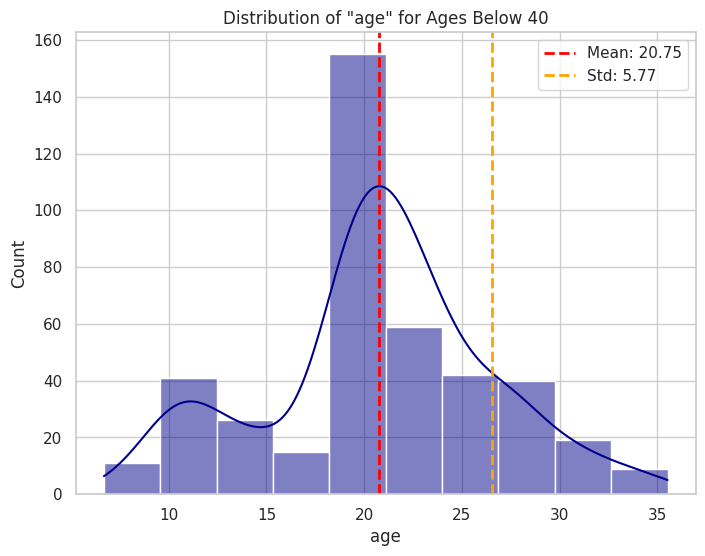

In [ ]:
# Histogram of the target column for patients below 40, including mean and std

## Filter data for ages below 40
filtered_df = df[df["age"] < 40]
## Histogram of numerical data, including mean and std
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
## Plot histogram
sns.histplot(data=filtered_df["age"], color="darkblue", kde=True, bins=10, ax=ax)
mean_val = filtered_df["age"].mean()
std_val = filtered_df["age"].std()
## Display mean and std
ax.axvline(
    mean_val,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Mean: {mean_val:.2f}",
)
ax.axvline(
    mean_val + std_val,
    color="orange",
    linestyle="dashed",
    linewidth=2,
    label=f"Std: {std_val:.2f}",
)
## Display title and legend
plt.title('Distribution of "age" for Ages Below 40')
plt.legend()
plt.show()


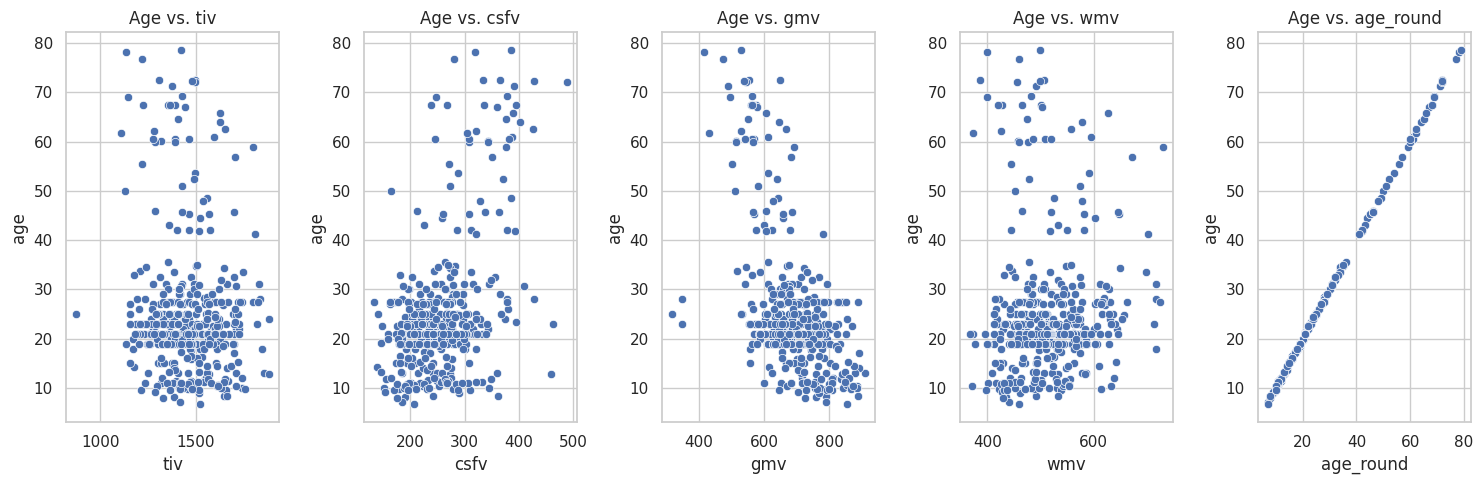

In [ ]:
# Scatter plot of age vs. numerical data
age_columns = ["age"]
num_cols_NoAge = [item for item in num_cols if item not in age_columns]

fig, axes = plt.subplots(1, len(num_cols_NoAge), figsize=(15, 5))
for i, col in enumerate(num_cols_NoAge):
    sns.scatterplot(data=df, x=col, y="age", ax=axes[i])
    axes[i].set_title(f"Age vs. {col}")

plt.tight_layout()
plt.show()

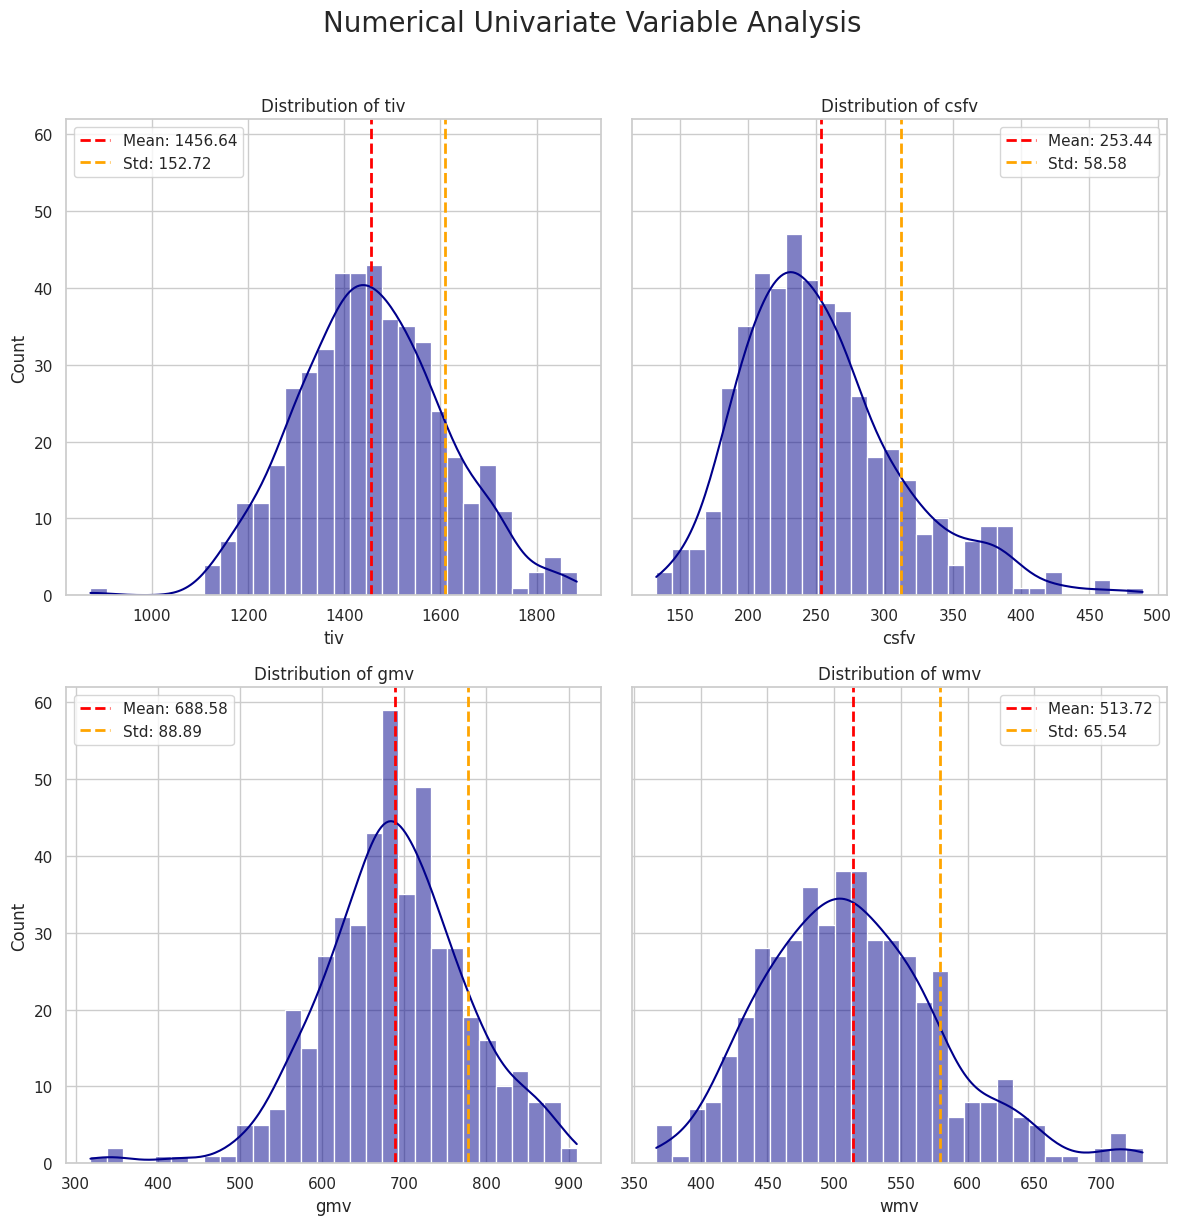

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms of numerical data, including mean and std
sns.set(style="whitegrid")

# Ensure num_cols is a list and determine the number of subplots based on the number of columns
num_cols = df_Num.columns[1:]
num_subplots = min(4, len(num_cols))
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

for i, col in enumerate(num_cols[:num_subplots]):
    ax = axes[i]

    # Plot histogram
    sns.histplot(data=df_Num[col], color="darkblue", kde=True, bins=30, ax=ax)

    # Calculate and display mean and std
    mean_val = df_Num[col].mean()
    std_val = df_Num[col].std()
    ax.axvline(
        mean_val,
        color="red",
        linestyle="dashed",
        linewidth=2,
        label=f"Mean: {mean_val:.2f}",
    )
    ax.axvline(
        mean_val + std_val,
        color="orange",
        linestyle="dashed",
        linewidth=2,
        label=f"Std: {std_val:.2f}",
    )

    ax.set_title(f"Distribution of {col}")
    ax.legend()

fig.suptitle("Numerical Univariate Variable Analysis", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


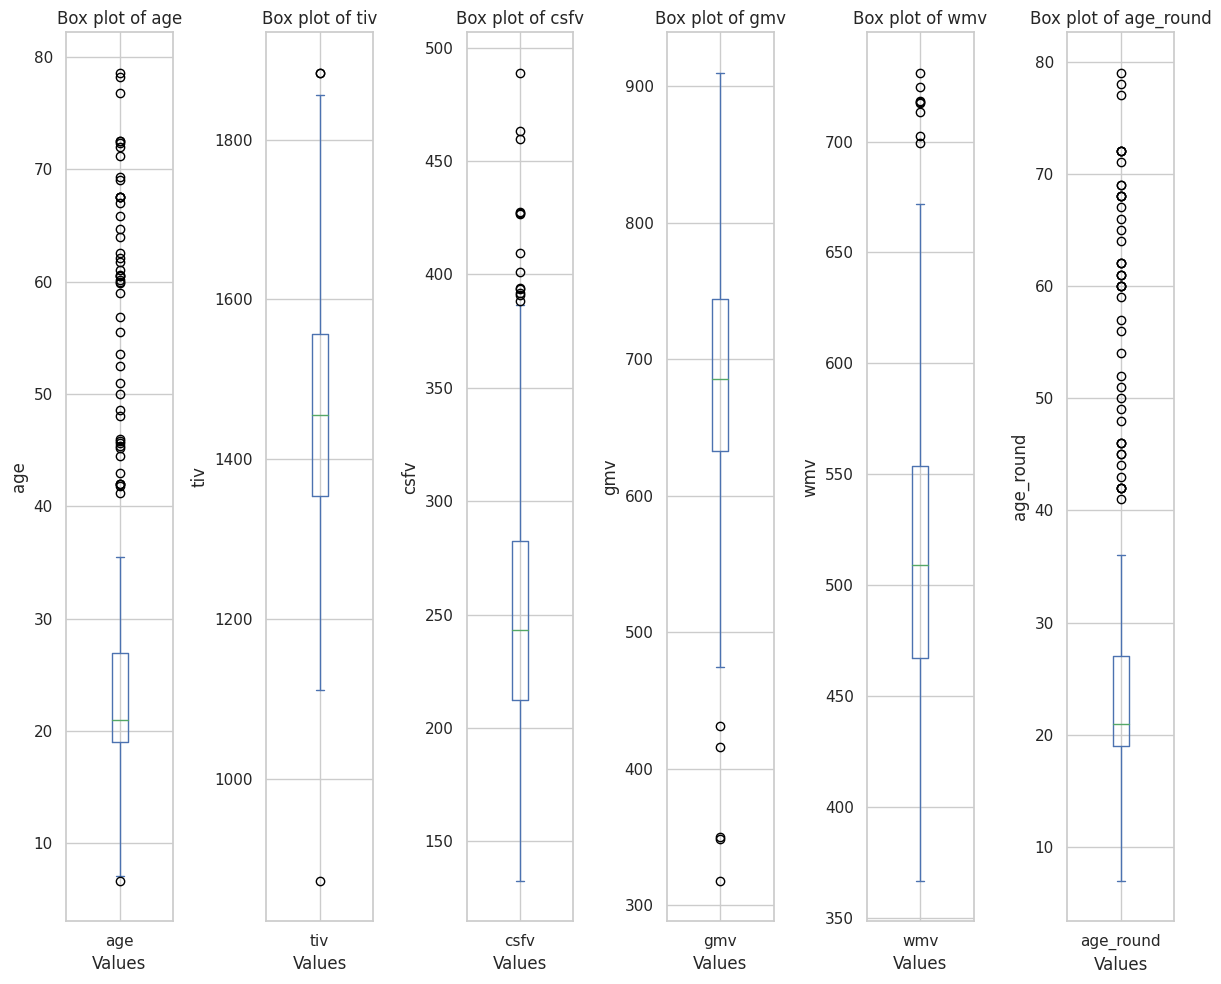

In [ ]:
# Box plots of age vs. data

fig, axes = plt.subplots(1, len(df_Num.columns), figsize=(12, 10))
for i, col in enumerate(df_Num.columns):
    df_Num[col].plot(kind="box", ax=axes[i])
    axes[i].set_title(f"Box plot of {col}")
    axes[i].set_xlabel("Values")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()


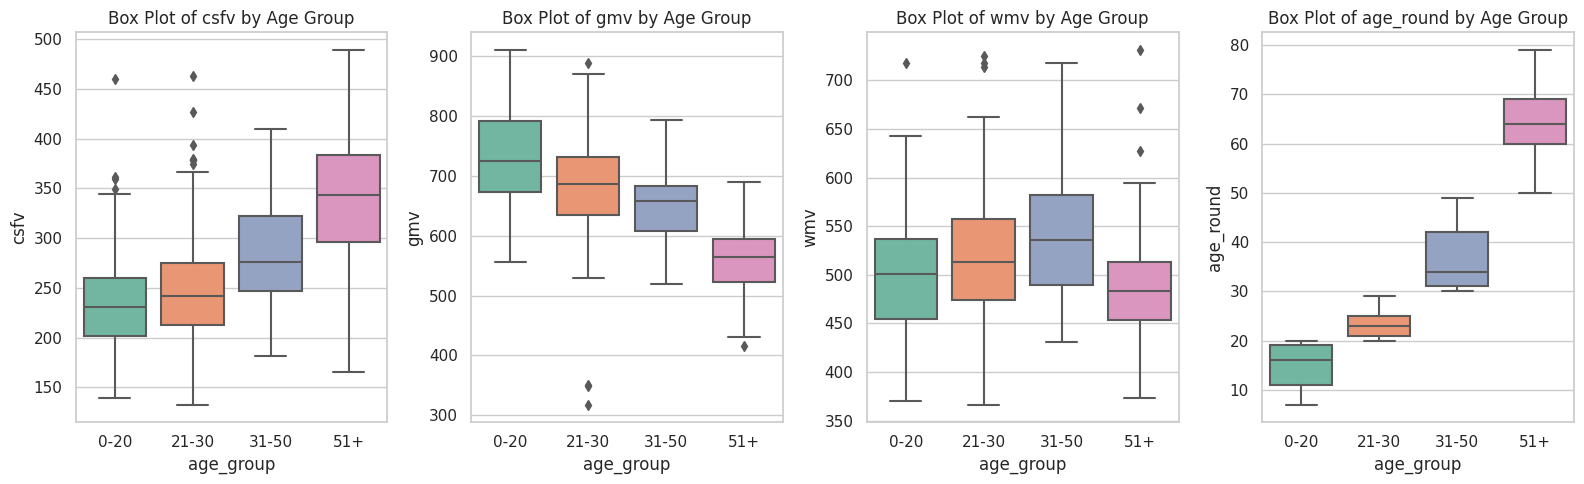

In [ ]:
# Boxplot of age categories vs. numerical data
age_bins = [0, 20, 30, 50, float("inf")]
age_labels = ["0-20", "21-30", "31-50", "51+"]
df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, right=False)

custom_palette = sns.color_palette("Set2")
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))  # Adjust figsize as needed

for i, col in enumerate(num_cols[1:5]):  # Loop through the desired columns
    sns.boxplot(data=df, x="age_group", y=col, palette=custom_palette, ax=axes[i])
    axes[i].set_title(f"Box Plot of {col} by Age Group")

plt.tight_layout()
plt.show()

# Drop the 'age_group' column from the DataFrame
df = df.drop("age_group", axis=1)


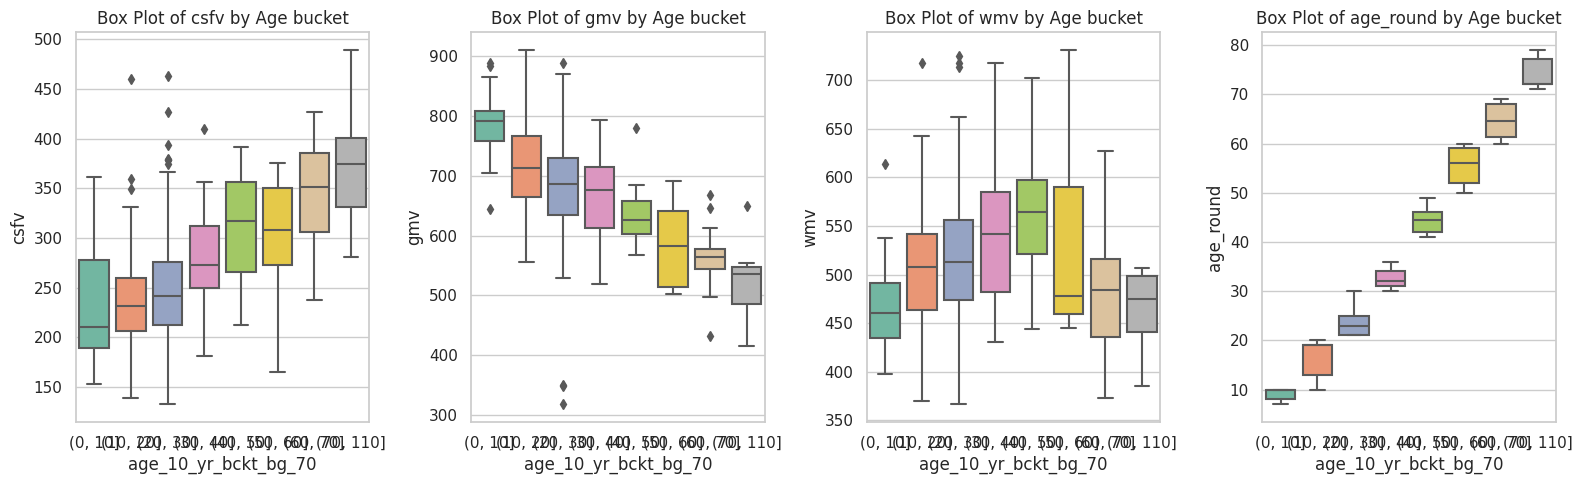

In [ ]:
# Boxplot of age buckets vs. numerical data
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))  # Adjust figsize as needed
for i, col in enumerate(num_cols[1:5]):  # Loop through the desired columns
    sns.boxplot(
        data=train_meta_df,
        x="age_10_yr_bckt_bg_70",
        y=col,
        palette=custom_palette,
        ax=axes[i],
    )
    axes[i].set_title(f"Box Plot of {col} by Age bucket")
plt.tight_layout()
plt.show()


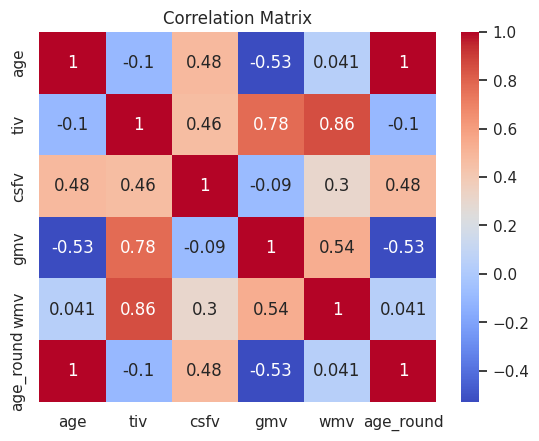

In [ ]:
# Correlation and feature independance

# Correlation matrix
corr_matrix_P = df_Num.corr()
corr_matrix_P
sns.heatmap(corr_matrix_P, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [ ]:
corr_matrix_P


,age,tiv,csfv,gmv,wmv,age_round
age,1.000000,-0.100883,0.481918,-0.528133,0.041493,0.999879
tiv,-0.100883,1.000000,0.464082,0.776828,0.859327,-0.100818
csfv,0.481918,0.464082,1.000000,-0.089873,0.302758,0.481815
gmv,-0.528133,0.776828,-0.089873,1.000000,0.537063,-0.527955
wmv,0.041493,0.859327,0.302758,0.537063,1.000000,0.041488
age_round,0.999879,-0.100818,0.481815,-0.527955,0.041488,1.000000


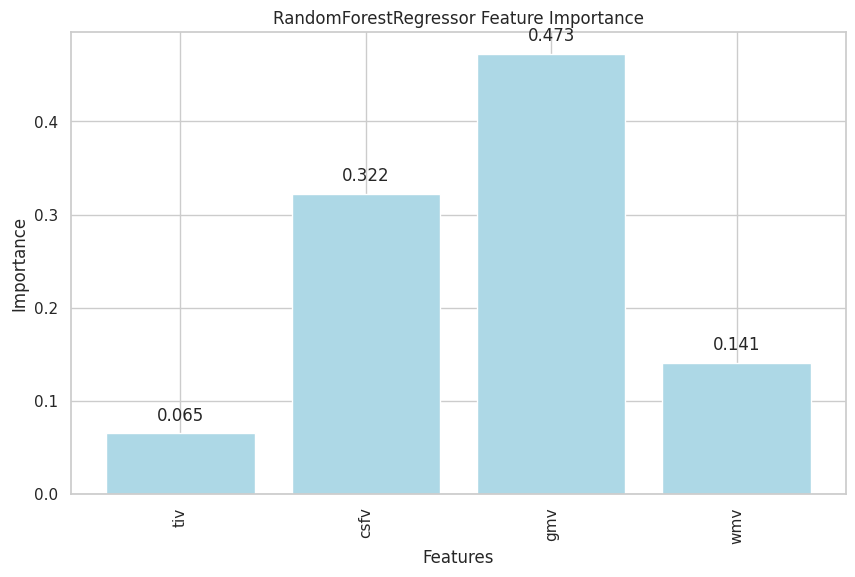

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target variable (y)
y = df_Num["age"]
X = df_Num.drop(columns=["age", "age_round"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the RandomForestRegressor model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Plot the feature importance
importance = model.feature_importances_

# Create a bar plot with annotations
fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(X.columns, importance, color="lightblue")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("RandomForestRegressor Feature Importance")
plt.xticks(rotation=90)

# Annotate each bar with its importance value
for bar, imp_value in zip(bars, importance):
    yval = imp_value + 0.01  # Adjust the vertical position of the annotation
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{imp_value:.3f}",
        ha="center",
        va="bottom",
        rotation=0,
    )

plt.show()


#### 3/ Multivariate data analysis


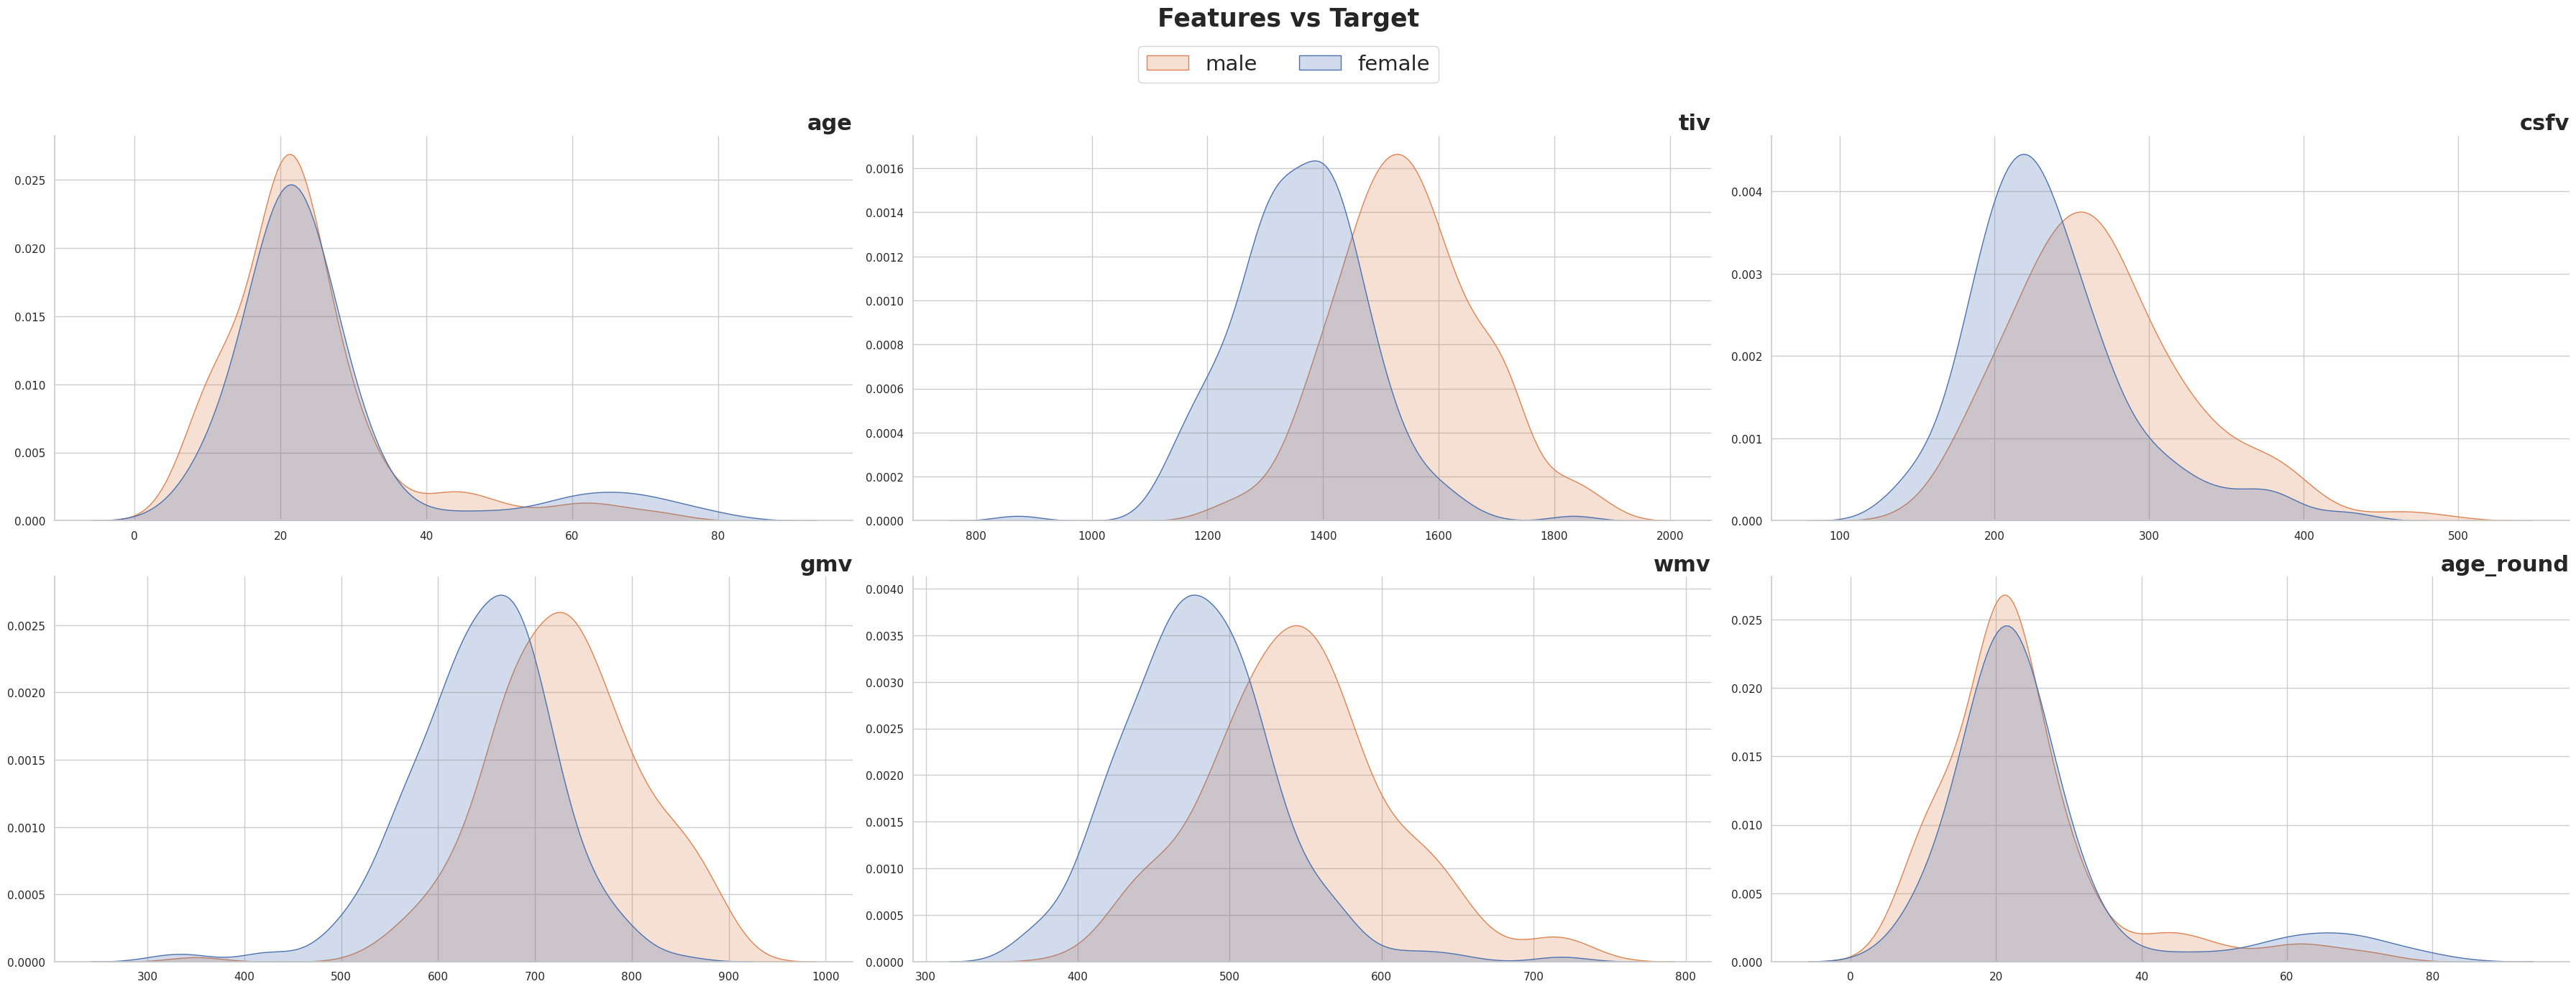

In [ ]:
# Plotting numerical values by gender
figsize = (6 * 6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(df_Num.columns):
    ax = plt.subplot(3, 3, idx + 1)
    sns.kdeplot(data=df, hue="sex", fill=True, x=col, legend=False)

    ax.set_ylabel("")
    ax.spines["top"].set_visible(False),
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.set_title(f"{col}", loc="right", weight="bold", fontsize=22)

fig.suptitle(f"Features vs Target\n\n\n", ha="center", fontweight="bold", fontsize=25)
fig.legend(
    ["male", "female"],
    loc="upper center",
    bbox_to_anchor=(0.5, 0.96),
    fontsize=21,
    ncol=3,
)
plt.tight_layout()
plt.show()

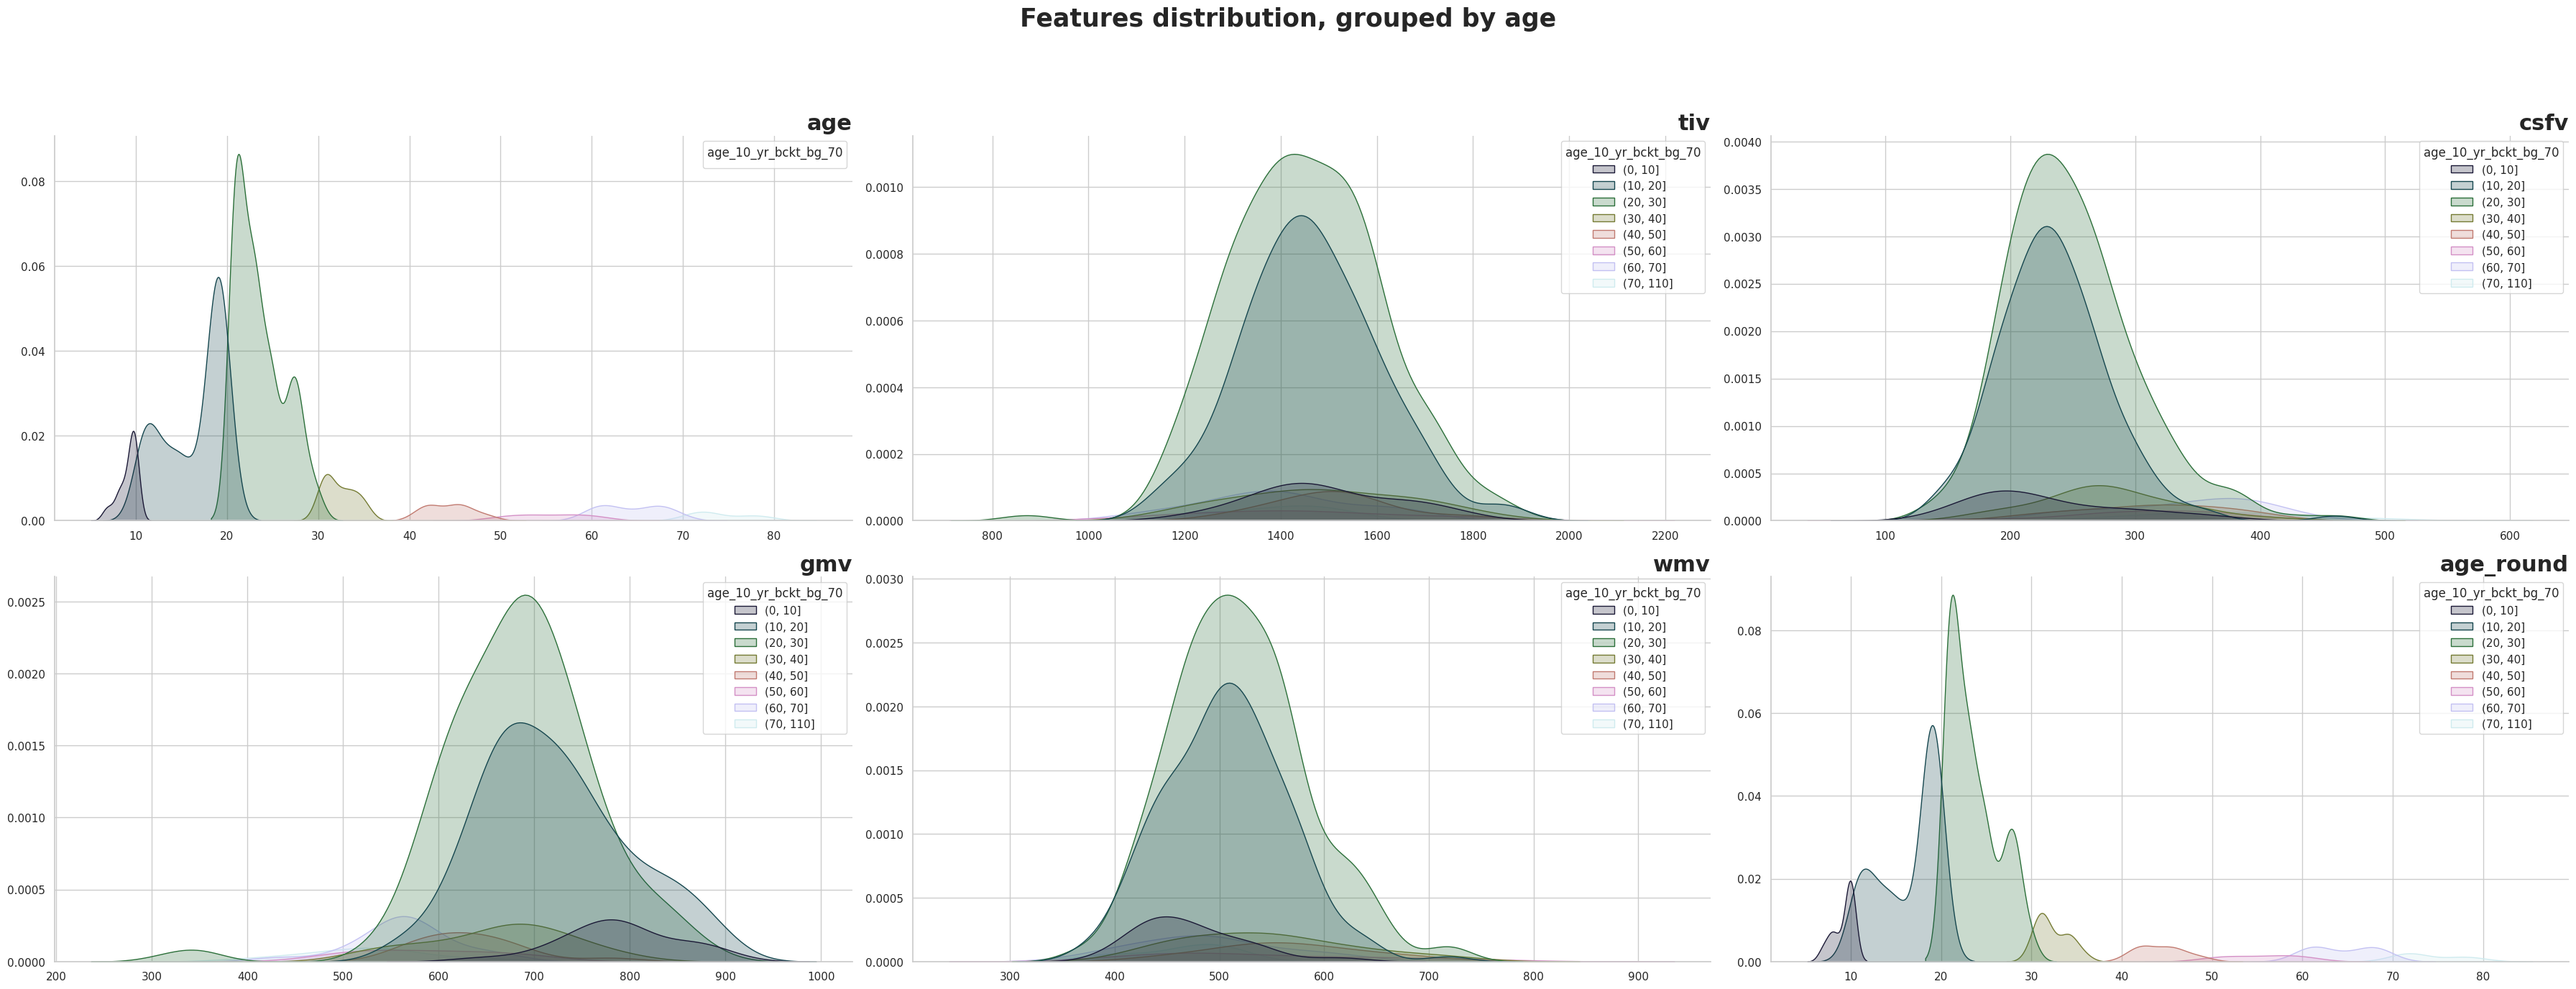

In [ ]:
# Features distribution, grouped by age

figsize = (6 * 6, 20)
fig = plt.figure(figsize=figsize)
cmap = sns.color_palette("viridis", as_cmap=True)
for idx, col in enumerate(df_Num.columns):
    ax = plt.subplot(3, 3, idx + 1)
    sns.kdeplot(
        data=df, hue="age_10_yr_bckt_bg_70", fill=True, palette="cubehelix", x=col
    )

    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.set_title(f"{col}", loc="right", weight="bold", fontsize=22)

    # Add legend to the first subplot only
    if idx == 0:
        ax.legend(title="age_10_yr_bckt_bg_70", loc="upper right")

fig.suptitle(
    f"Features distribution, grouped by age\n\n\n",
    ha="center",
    fontweight="bold",
    fontsize=25,
)
plt.tight_layout()
plt.show()

On observe 2 groupes, dont 1 avec tout au dessus de l'autre ( le orange)
coherent avec les matrices de correlation qui ne comportent que des nombres positifs


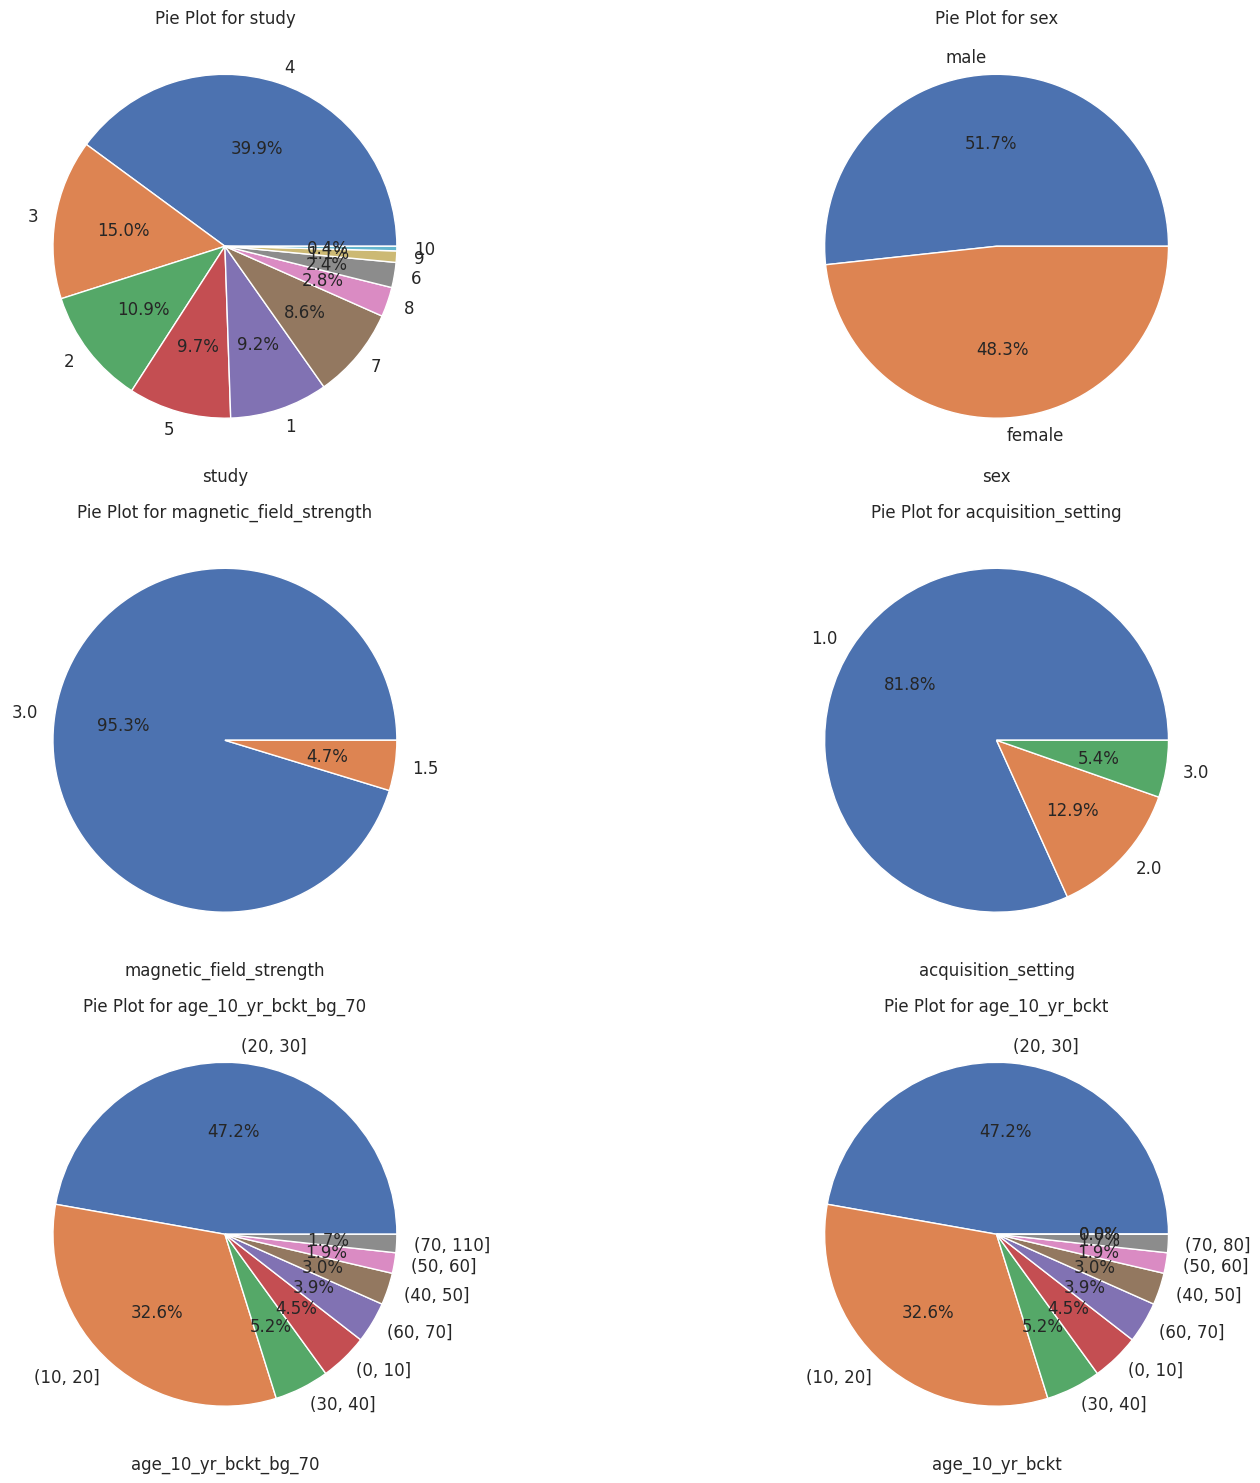

In [ ]:
#Categorical data -> Pie plots
num_cols = len(df_Cat.columns)
num_rows = (num_cols + 1) // 2  # Calculate the number of rows needed
fig, axes = plt.subplots(num_rows, 2, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(df_Cat.columns):
    df[col].value_counts().plot(kind="pie", ax=axes[i], autopct="%1.1f%%", fontsize=12)
    axes[i].set_title(f"Pie Plot for {col}")
    axes[i].set_ylabel("")
    axes[i].set_xlabel(col)

# Remove empty subplots in case num_cols is odd
for i in range(num_cols, num_rows * 2):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

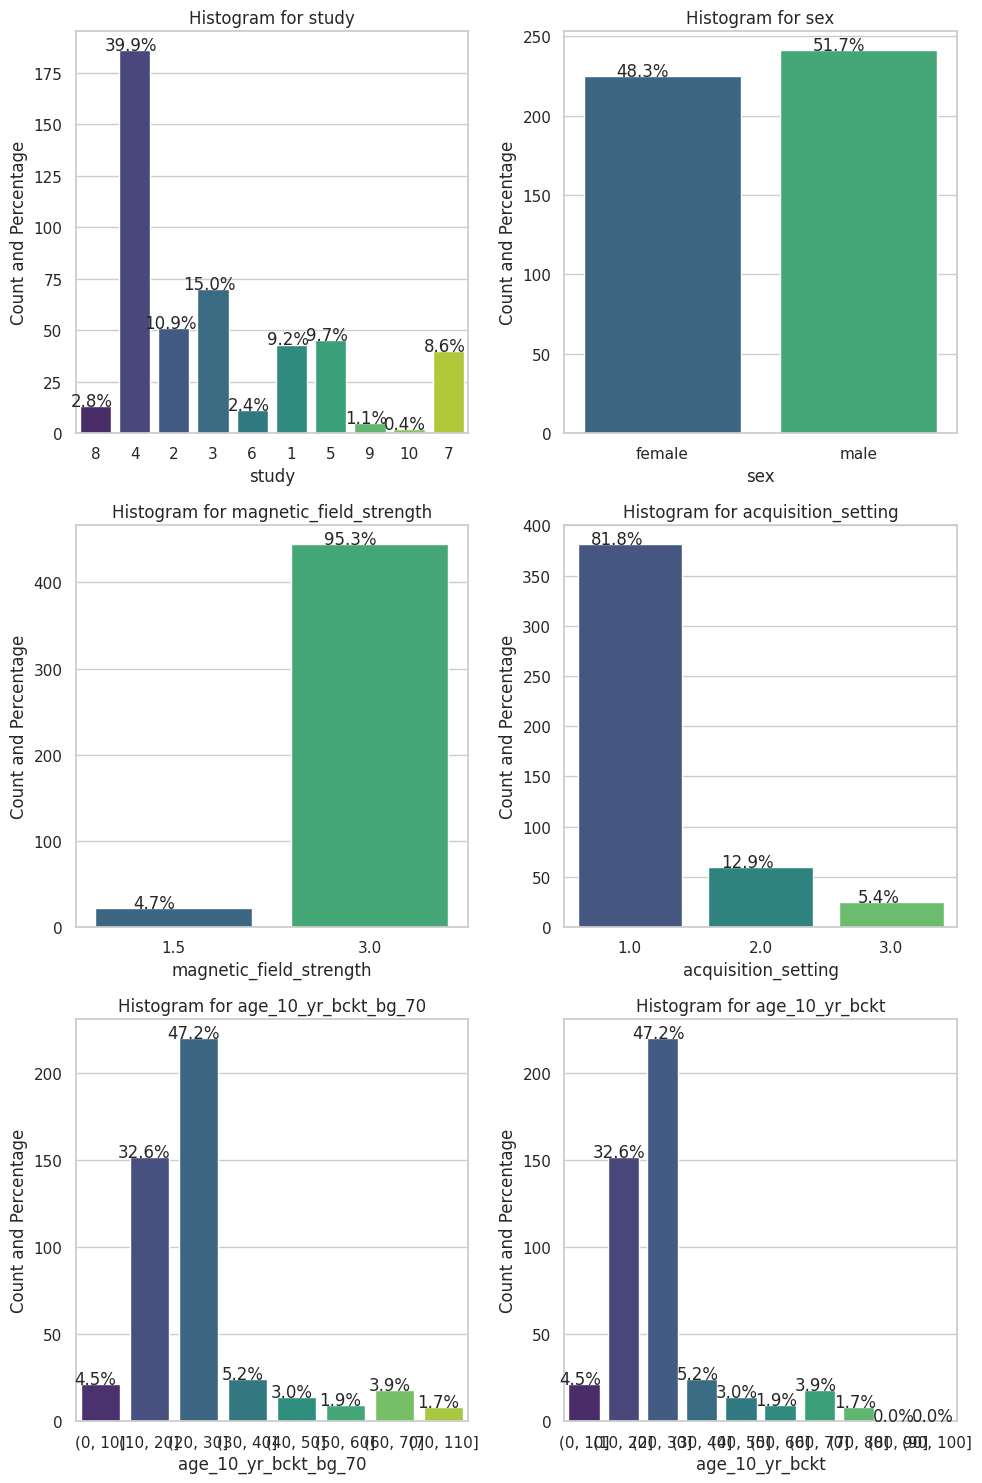

In [ ]:
#Categorical data -> Histograms
num_cols = len(df_Cat.columns)
num_rows = (num_cols + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(df_Cat.columns):
    sns.countplot(data=df_Cat, x=column, palette="viridis", ax=axes[i])
    total = float(len(df_Cat[column]))
    for p in axes[i].patches:
        percentage = "{:.1f}%".format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_height() + 0.05
        axes[i].annotate(percentage, (x, y), ha="center")

    axes[i].set_title(f"Histogram for {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count and Percentage")

plt.tight_layout()
plt.show()

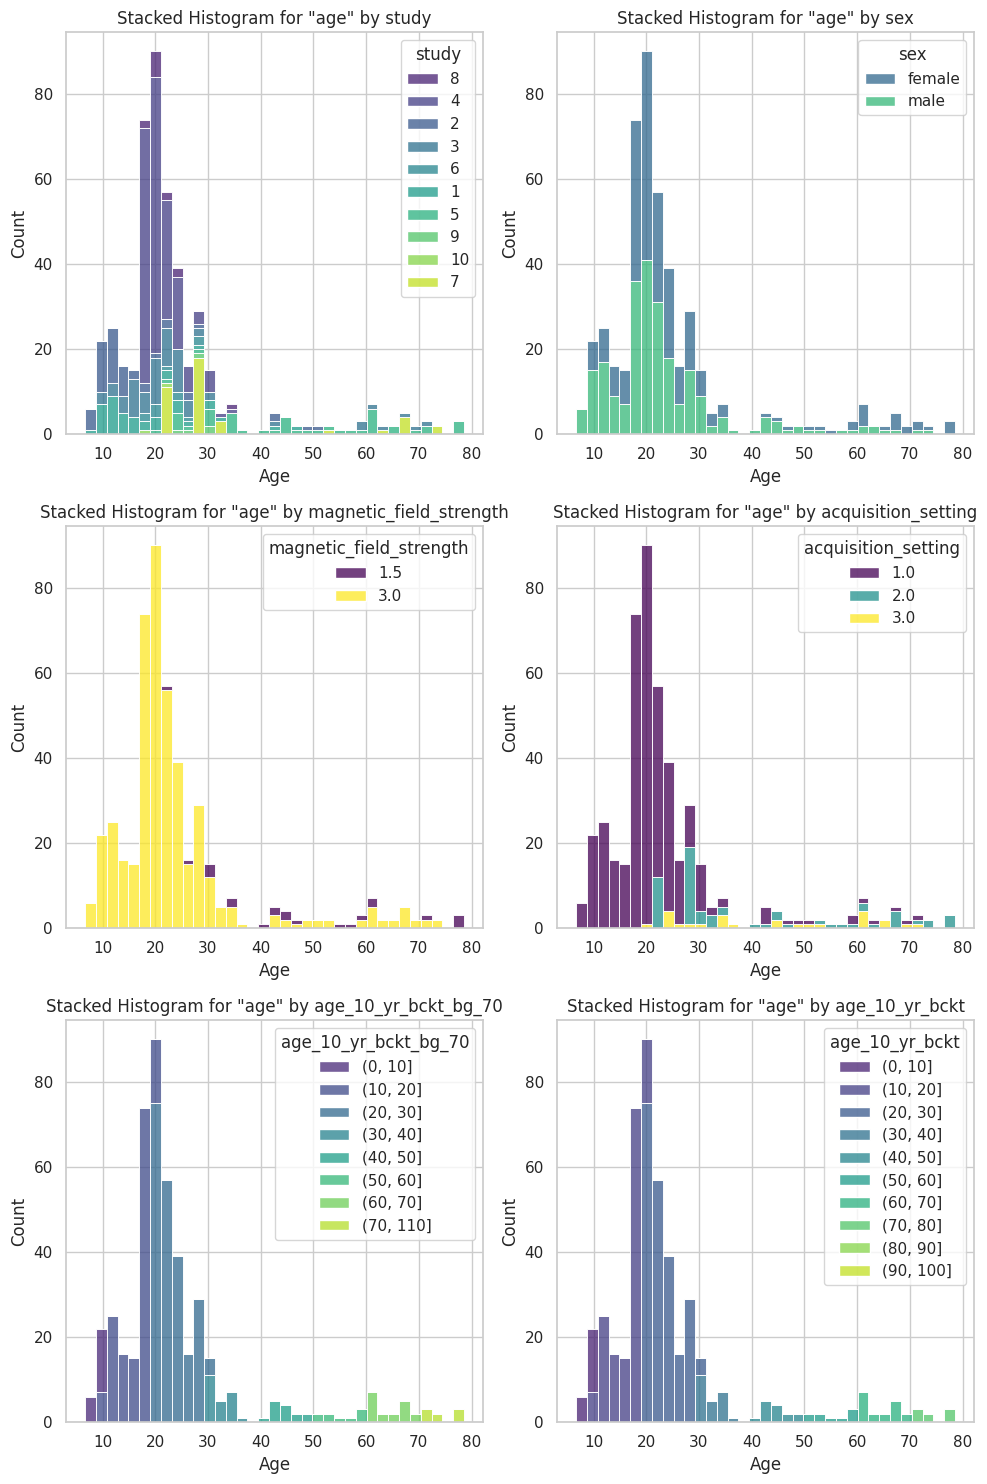

In [ ]:
# Age histograms, stacked by categorical values
num_cols = len(df_Cat.columns)
fig, axes = plt.subplots(num_cols // 2, 2, figsize=(10, 5 * (num_cols // 2)))
axes = axes.flatten()

for i in range(0, num_cols, 2):
    column1 = df_Cat.columns[i]
    column2 = df_Cat.columns[i + 1]

    sns.histplot(
        data=df, x="age", hue=column1, multiple="stack", ax=axes[i], palette="viridis"
    )
    axes[i].set_title(f'Stacked Histogram for "age" by {column1}')
    axes[i].set_xlabel("Age")
    axes[i].set_ylabel("Count")

    sns.histplot(
        data=df,
        x="age",
        hue=column2,
        multiple="stack",
        ax=axes[i + 1],
        palette="viridis",
    )
    axes[i + 1].set_title(f'Stacked Histogram for "age" by {column2}')
    axes[i + 1].set_xlabel("Age")
    axes[i + 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

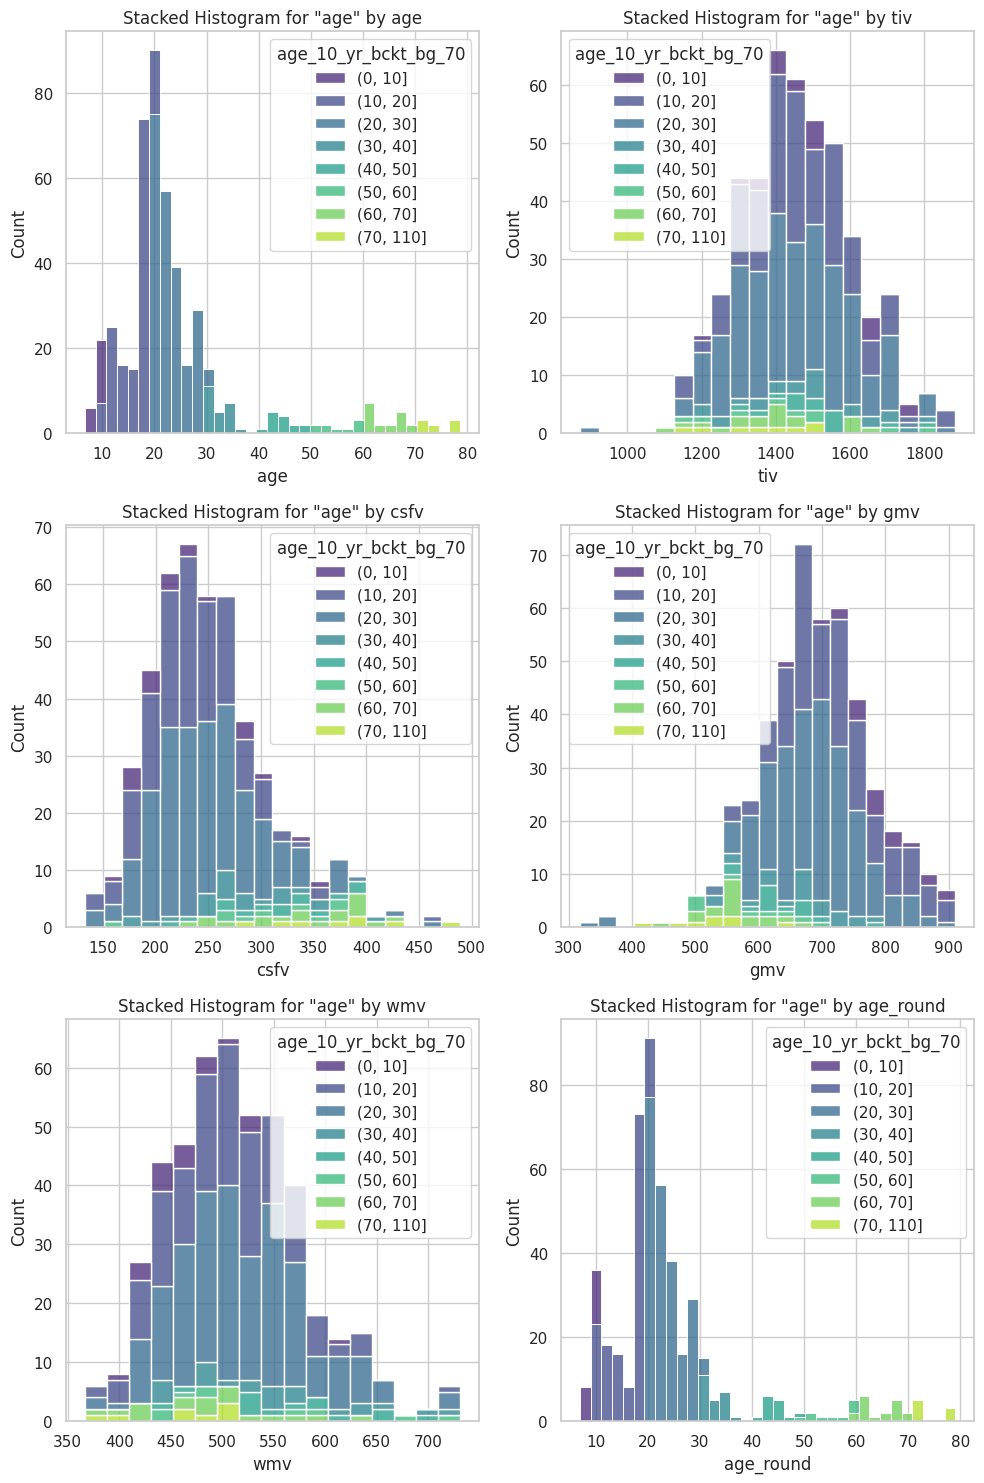

In [ ]:
# Histograms of numerical data, stacked by age categories
num_cols = len(df_Num.columns)
fig, axes = plt.subplots(num_cols // 2, 2, figsize=(10, 5 * (num_cols // 2)))
axes = axes.flatten()

for i, col in enumerate(df_Num.columns):
    sns.histplot(
        data=df,
        x=col,
        hue="age_10_yr_bckt_bg_70",
        multiple="stack",
        ax=axes[i],
        palette="viridis",
    )
    axes[i].set_title(f'Stacked Histogram for "age" by {col}')
    axes[i].set_xlabel(f"{col}")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

🚧 **Exercise 1.2** 🚧

In the code block below, add:

- `train_prop`: The proportion of the train data that you will assign to training the model (where the remaining will be used for validation)
- `stratification_variables`: Whether you intend to stratify by any variables when creating the train/validation split
- `test_metric`: The metric you intend to use to assess performance on the test set

(Stratified sampling is a technique used to ensure that the subsets of the data (in this case, training, validation, and test sets) are representative of the whole dataset. This is especially important in cases where the dataset is not homogeneous and contains distinct groups that should be evenly represented in each set.)


In [ ]:
# Exercise: input answer here

# Your code here
train_prop = 0.8
stratification_variables = [
    "age_10_yr_bckt_bg_70",
    "acquisition_setting",
    "study",
]  # samples are randomly selected from each stratum, we want to make sure that all strata are represented in the training and test sets
# a list of variables from the meta data, e.g. ["variable_1", "variable_2"]. Ensure you choose at least one variable, or the code will not run!
test_metric = torch.nn.MSELoss()
  # This is not used later in the notebook, but it is good to decide it now
  # MSE is a good metric for regression problems
# Your code here - END

The code below defines three numpy arrays `train_pats`, `val_pats` and `test_pats` containing a (potentially stratified) random selection of patient ids assigned to the respective datasets.


In [ ]:
grp_df = train_meta_df.groupby(by=stratification_variables)
train_pats = []
val_pats = []
test_pats = []
for idx, grp in grp_df:
    train, val = np.split(
        grp["participant_id"], [int(np.floor(grp.shape[0] * train_prop))]
    )
    train_pats.append(train)
    val_pats.append(val)
train_pats = np.concatenate(train_pats)
val_pats = np.concatenate(val_pats)
test_pats = test_meta_df["participant_id"].values

with open(os.path.join(TRAIN_DIR, "train_pats.pkl"), "wb") as f:
    pickle.dump(train_pats, f)
with open(os.path.join(TRAIN_DIR, "val_pats.pkl"), "wb") as f:
    pickle.dump(val_pats, f)
with open(os.path.join(TEST_DIR, "test_pats.pkl"), "wb") as f:
    pickle.dump(test_pats, f)

print(f"Num training patients: {len(train_pats)}")
print(f"Num validation patients: {len(val_pats)}")
print(f"Num testing patients: {len(test_pats)}")

Num training patients: 351
Num validation patients: 115
Num testing patients: 167


## Part 2: Baseline model definition

Now the model development assumptions have been defined, a baseline model needs to be developed. This baseline model should act as a spring board for your subsequent model development. Ideally should balance the following objectives:

- Attain a **reasonable** level of performance, and;
- Be **simple**! This is almost the most important requirement since if the model is too complex, understanding which areas of the archtecture are underperforming will be challenging!

In this exercise the baseline model should be defined by the following pipeline:

1. **Volume prediction:** A deep learning model is trained to take in patient MRI images and predict three patient brain volume values (explained in more detail below).
2. **MLP Regression:** A multi-layer perceptron regression model takes patient brain volume values as input and predicts patient age.

These models will be trained seperately, then combined to make end-to-end MRI -> age predictions at test time. We elaborate more on the motivation behind this pipeline below.

**Your main task** will be to define the deep learning Volume Prediction model and subsequently justify and explain your design choices.

_Hints_:

- What might be a 'simple' go-to deep learning architecture for processing images?
- Do 3D images need to be treated differently to 2D images (see Pytorch [CONV3D](https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html#conv3d)...)
- How might 'reasonable' be defined?
  - Does the baseline perform better than random chance?
  - Does the baseline perform better than just applying a linear regression or xgBoost model directly on the images?
- As this is a baseline, performance is not expected to be excellent. As you are only expected to implement the volume predictor, it is ok if other parts of the pipline are limiting. However, you may make small modifications to the mlp training, etc. to ensure reasonable performance.


### 2.1. Settings and motivations


#### 2.1.1. Settings for the VolumePrediction model


##### 2.1.1.a. Data Helpers

Before we begin, lets load and process the data.


We will create seperate dataloaders for the volume prediction task and the linear regression task.

First, we create the volume prediction data loaders. This data loader provides a batch of 3D MRI images as 'X', and the corresponding brain volume labels as 'y'. The train/val/test splits you decided previously will be used.


In [ ]:
def zero_mean_unit_var(img_array: np.array) -> np.array:
    """Function to normalise an input image to have 0 mean and unit variance

    Args:
        img_array (np.array): 3D numpy array representing the MRI scan

    Returns:
        np.array: Normalised version of img_array
    """
    mean = np.mean(img_array)
    std = np.std(img_array)
    # Capture 0 values as these are background
    zero_values = img_array == 0
    if std > 0:
        img_array = (img_array - mean) / std
        img_array[zero_values] = 0
    return img_array


def resample_image(
    img_array: np.array,
    out_spacing: Tuple[float] = (1.0, 1.0, 1.0),
    out_size: Tuple[float] = None,
    is_label: bool = False,
    pad_value=0,
) -> np.array:
    """Function to alter the proportions of an input image represented as a
    numpy array

    Args:
        img_array (np.array): 3D numpy array representing the MRI scan
        out_spacing (Tuple[float], optional): ???. Defaults to (1.0, 1.0, 1.0).
        out_size (Tuple[float], optional): Tuple of length 3 defining the
        desired output dimensions of the image. Defaults to None.
        is_label (bool, optional): ???. Defaults to False.
        pad_value (int, optional): ???. Defaults to 0.

    Returns:
        np.array: _description_
    """

    image = sitk.GetImageFromArray(img_array)
    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(
            np.array(original_size * original_spacing / np.array(out_spacing))
        ).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(
        len(original_spacing), -1
    )
    original_center = (
        (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    )
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return sitk.GetArrayFromImage(resample.Execute(image))


class VolumePredictionDataset(Dataset):
    """
    Important: By default, this dataset returns normalized versions of the input MRI images and output volume labels.
    """

    def __init__(
        self,
        patient_list: List[str],
        mri_file_dir: str,
        meta_df: pd.DataFrame,
        volume_norm_stats: Dict[str, np.array],
        out_spacing=OUT_SPACING,
        out_size=OUT_SIZE,
    ):
        self.samples: List[Dict[str, torch.tensor]] = []

        for pat in tqdm(patient_list, desc="Loading Data"):
            # MRI image
            X = load_patient_mri_array(pat, mri_dir=mri_file_dir).squeeze()
            X = zero_mean_unit_var(X)
            if (out_spacing is not None) and (out_size is not None):
                X = resample_image(X, out_spacing=out_spacing, out_size=out_size)
            X = torch.from_numpy(X).unsqueeze(0).float()

            # Volume labels
            y = meta_df[meta_df["participant_id"] == pat][
                ["csfv", "gmv", "wmv"]
            ].values.squeeze()
            y = (y - volume_norm_stats["mean"]) / volume_norm_stats["std"]
            y = torch.from_numpy(y).float()

            sample = {"X": X, "y": y}
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item]


##### 2.1.1.b. Data normalisation

In our datasets, we will normalize both the input and the output data for model training. Images are simply normalized to each have zero mean and unit variance. Volumes and ages are normalized using statistics of the train dataset, calculated below.


In [ ]:
# Normalization stats

ages_norm_stats = {
    "mean": train_meta_df["age"].mean(axis=0),
    "std": train_meta_df["age"].std(axis=0),
}

volume_norm_stats = {
    "mean": train_meta_df[["csfv", "gmv", "wmv"]].mean(axis=0).values,
    "std": train_meta_df[["csfv", "gmv", "wmv"]].std(axis=0).values,
}

display(ages_norm_stats)
display(volume_norm_stats)


{'mean': 24.730252048494517, 'std': 13.336105435557256}

{'mean': array([253.44248979, 688.5824933 , 513.71863709]),
 'std': array([58.58350478, 88.89055568, 65.53866211])}

##### 2.1.1.c. Loading the data


In [ ]:
# ! DO NOT RERUN: Very long code - Takes 8 min

batch_size = 8  # Can be changed if you wish

# Training
vol_train_data = VolumePredictionDataset(
    patient_list=train_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
)
vol_train_loader = DataLoader(vol_train_data, batch_size=batch_size)

# Validation
vol_val_data = VolumePredictionDataset(
    patient_list=val_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
)
vol_val_loader = DataLoader(vol_val_data, batch_size=batch_size)

# Testing
vol_test_data = VolumePredictionDataset(
    patient_list=test_pats,
    mri_file_dir=TEST_MRI_DIR,
    meta_df=test_meta_df,
    volume_norm_stats=volume_norm_stats,
)

# Check the number of batches in each DataLoader
num_batches_train = len(vol_train_loader)
num_batches_val = len(vol_val_loader)
num_batches_test = len(DataLoader(vol_test_data, batch_size=batch_size))

print(f"Number of batches in training DataLoader: {num_batches_train}")
print(f"Number of batches in validation DataLoader: {num_batches_val}")
print(f"Number of batches in testing DataLoader: {num_batches_test}")

# Check the output of the dataloader
tmp = next(vol_train_loader.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (MRI images) dimensions are: {tmp['X'].shape}")
print(f"The output (csfv, gmv, wmv brain volumes) dimensions are: {tmp['y'].shape}")


Loading Data: 100%|██████████| 167/167 [01:42<00:00,  1.62it/s]

Number of batches in training DataLoader: 44
Number of batches in validation DataLoader: 15
Number of batches in testing DataLoader: 21
Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input (MRI images) dimensions are: torch.Size([8, 1, 96, 96, 96])
The output (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([8, 3])


Ensure you understand what the inputs and outputs represent, and what each axis of the data represents.

Next, we define the data loaders for the MLP age regression task. These return brain volumes as 'X' and age labels as 'y'.


#### 2.1.2. Settings for the MLP age regression task


In [ ]:
class AgeRegressionDataset(Dataset):
    """
    Important:
    - By default, this dataset returns normalized versions of the input volumes and output age labels.
    """

    def __init__(
        self,
        patient_list: List[str],
        meta_df: pd.DataFrame,
        volume_norm_stats: Dict[str, np.array],
        ages_norm_stats: Dict[str, np.array],
    ):
        self.samples: List[Dict[str, torch.tensor]] = []

        for pat in tqdm(patient_list, desc="Loading Data"):
            # Brain volumes
            X = meta_df[meta_df["participant_id"] == pat][
                ["csfv", "gmv", "wmv"]
            ].values.squeeze()
            X = (X - volume_norm_stats["mean"]) / volume_norm_stats["std"]
            X = torch.from_numpy(X).float()

            # Ages
            y = meta_df[meta_df["participant_id"] == pat][["age"]].values.squeeze()
            y = (y - ages_norm_stats["mean"]) / ages_norm_stats["std"]
            y = torch.tensor(y).float()

            sample = {"X": X, "y": y}
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item]

In [ ]:
rnd_seed = 42
batch_size = 2

## Training
mlp_train_data = AgeRegressionDataset(
    patient_list=train_pats,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
    ages_norm_stats=ages_norm_stats,
)
mlp_train_loader = DataLoader(mlp_train_data, batch_size=batch_size)

## Validation
mlp_val_data = AgeRegressionDataset(
    patient_list=val_pats,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
    ages_norm_stats=ages_norm_stats,
)
mlp_val_loader = DataLoader(mlp_val_data, batch_size=batch_size)

tmp = next(mlp_train_loader.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (csfv, gmv, wmv brain volumes) dimensions are: {tmp['X'].shape}")
print(f"The output (patient age) dimensions are: {tmp['y'].shape}")


Loading Data: 100%|██████████| 115/115 [00:00<00:00, 443.49it/s]

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([2, 3])
The output (patient age) dimensions are: torch.Size([2])


Again, ensure you understand what the inputs and outputs represent, and what each axis of the data represents.


#### 2.1.3. Motivating the baseline model pipeline

Our training dataset provides ground-truth information about patient brain volumes, namely:

- csfv: Cerebrospinal fluid volume
- gmv: Grey matter volume
- wmv: White matter volume

It has been found previously that these brain volumes are correlated with age. Lets investigate if that is the case in our dataset. If so, these values could be useful for our task of predicting brain age!


In [ ]:
# Get ages
ages = train_meta_df["age"].values

# Get volumes
volumes = train_meta_df[["csfv", "gmv", "wmv"]].values
csfv = volumes[:, 0]
gmv = volumes[:, 1]
wmv = volumes[:, 2]

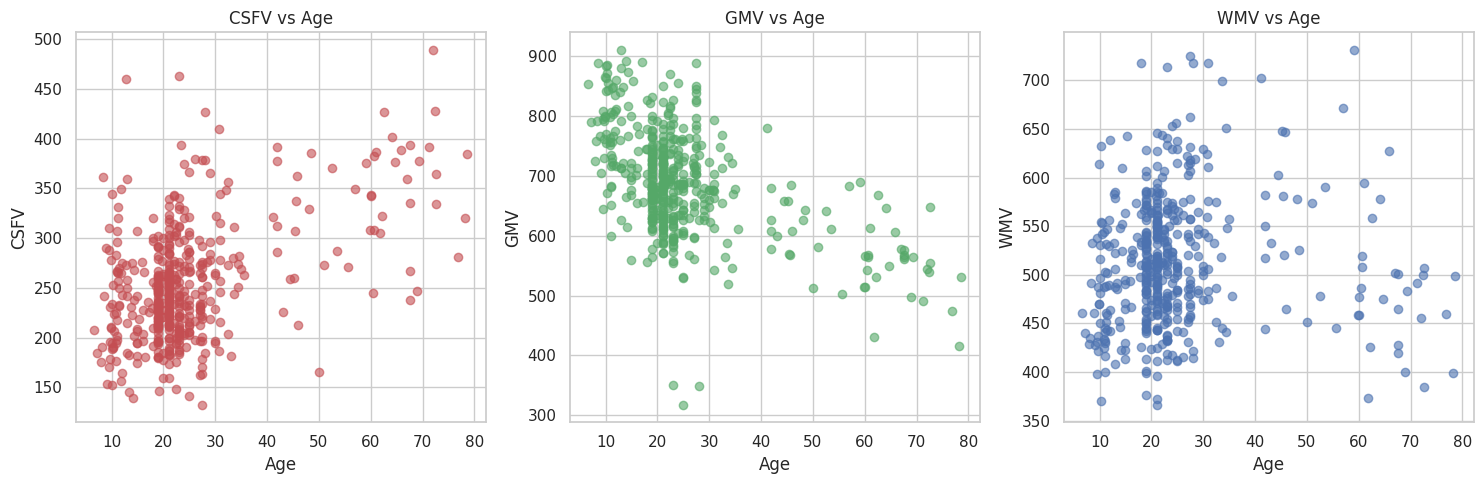

In [ ]:
# Create scatter plots to visualize the correlation between volumes and age

import matplotlib.pyplot as plt

# Create a figure and a 1x3 subplot (for 3 plots in a row)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot csfv vs age
axes[0].scatter(ages, csfv, color="r", alpha=0.6)
axes[0].set_title("CSFV vs Age")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("CSFV")

# Plot gmv vs age
axes[1].scatter(ages, gmv, color="g", alpha=0.6)
axes[1].set_title("GMV vs Age")
axes[1].set_xlabel("Age")
axes[1].set_ylabel("GMV")

# Plot wmv vs age
axes[2].scatter(ages, wmv, color="b", alpha=0.6)
axes[2].set_title("WMV vs Age")
axes[2].set_xlabel("Age")
axes[2].set_ylabel("WMV")

# Display the plots
plt.tight_layout()
plt.show()


We see some visual evidence here that age is correlated with the brain volumes. This means the brain volume information may be useful for predicting age.

Thus, we may be able to split our baseline model into two parts: (i) Volume Prediction Model: a deep learning model that predicts brain volumes from MRI images; and (ii) MLP Regression Model: a multi-layer perceptron regression model that predicts age from brain volumes.

Note, this approach leverages the brain volume information available to in the training data, but will not require any ground-truth brain volume information at deplyoment! (At training, the Linear Regression Model will be trained to map from ground-truth volumes to age. But at deployment it will take volume values predicted by the Volume Prediction Model).


### 2.2. Baseline: MLP Regression training


First lets train the MLP regression model.


Lets define some standard training and testing functions.

(**Optional Exercise**: You may modify these training and testing functions if you wish to add more sophisticated logging)


#### 2.2.1. Defining training, testing functions and MLP regression model


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    model.train()

    total_loss = 0
    for step, data in enumerate(dataloader):
        X, y = data["X"].to(device), data["y"].to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / num_batches
    print(f"Train loss: {average_loss:>7f}")

In [ ]:
def test(dataloader, model, loss_fn, y_norm_stats):
    def denorm(y):
        return y.cpu() * y_norm_stats["std"] + y_norm_stats["mean"]

    num_batches = len(dataloader)
    model.eval()

    test_loss, mae_loss = 0, 0
    with torch.no_grad():
        for data in dataloader:
            X, y = data["X"].to(device), data["y"].to(device)
            pred = model(X)

            test_loss += loss_fn(pred, y).item()
            mae_loss += torch.mean(torch.abs(denorm(pred) - denorm(y))).item()

    test_loss /= num_batches
    mae_loss /= num_batches
    print(f"Test loss: {test_loss:>8f}, MAE: {mae_loss:>8f}\n")

Now define the linear regression model in pytorch.


In [ ]:
# Defining the MLP Model
class MLPRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(MLPRegression, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x


# Fetching the batches
tmp = next(mlp_train_loader.__iter__())
in_shape = tmp["X"].shape[1:]

mlp_model = MLPRegression(in_shape[0]).float().to(device)

output = mlp_model(tmp["X"].to(device))
print("MLP Regression Model output shape: ", output.shape)


MLP Regression Model output shape:  torch.Size([2, 1])


Now train the lmlp regression model


#### 2.2.2. Training the MLP model


In [ ]:
# Defining the training parameters - MLP
mlp_loss_fn = nn.MSELoss()
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)


In [ ]:
# Training
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(mlp_train_loader, mlp_model, mlp_loss_fn, mlp_optimizer)
    test(mlp_val_loader, mlp_model, mlp_loss_fn, ages_norm_stats)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss: 0.662120
Test loss: 1.206357, MAE: 11.743340

Epoch 2
-------------------------------
Train loss: 0.663859
Test loss: 0.848692, MAE: 9.459577

Epoch 3
-------------------------------
Train loss: 0.551236
Test loss: 0.754337, MAE: 8.849427

Epoch 4
-------------------------------
Train loss: 0.523610
Test loss: 0.712662, MAE: 8.535433

Epoch 5
-------------------------------
Train loss: 0.506574
Test loss: 0.689211, MAE: 8.324941

Epoch 6
-------------------------------
Train loss: 0.494503
Test loss: 0.675481, MAE: 8.183171

Epoch 7
-------------------------------
Train loss: 0.485162
Test loss: 0.666492, MAE: 8.073873

Epoch 8
-------------------------------
Train loss: 0.478794
Test loss: 0.661116, MAE: 8.000709

Epoch 9
-------------------------------
Train loss: 0.470637
Test loss: 0.655306, MAE: 7.929405

Epoch 10
-------------------------------
Train loss: 0.465514
Test loss: 0.651238, MAE: 7.874798

Epoch 11
-------------------------------
Train loss: 0.459931
Test l

If all has gone well, you should see the loss decreasing on both the train and validation data


Lets check some predictions to visually inspect the models accuracy.


R2 Score: 0.5806
Mean Squared Error: 63.6562


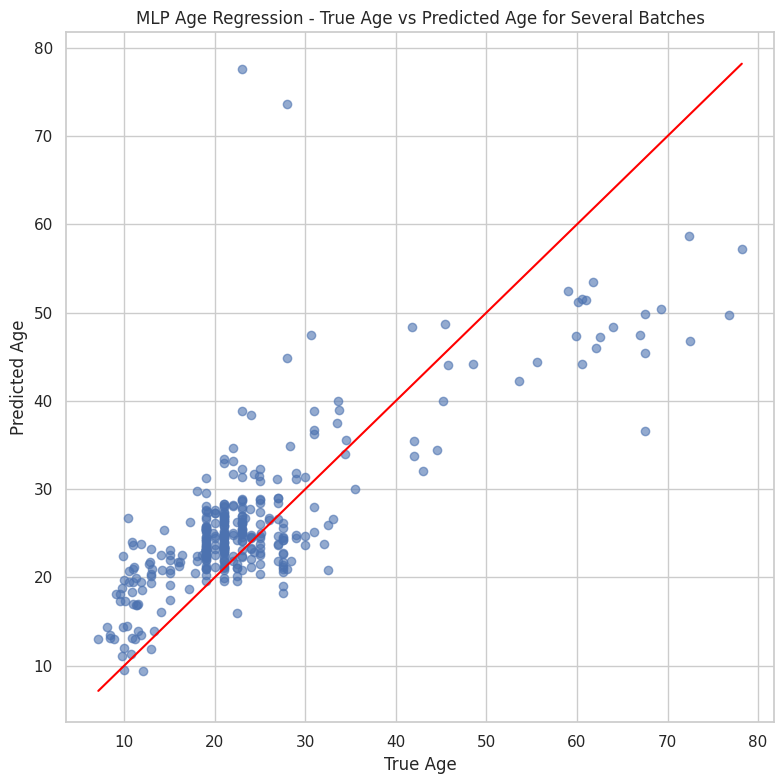

In [ ]:
true_ages_list = []
predicted_ages_list = []

# Loop through the loader for a certain number of batches (e.g., 10 batches in this example)
for i, batch in enumerate(mlp_train_loader):
    with torch.no_grad():
        inputs = batch["X"].to(device)
        true_ages = batch["y"].cpu().numpy().reshape(-1)
        predicted_ages = mlp_model(inputs).detach().cpu().numpy().reshape(-1)
    true_ages_list.extend(true_ages)
    predicted_ages_list.extend(predicted_ages)

# Denormalize the true and predicted ages
true_ages_list = (
    np.array(true_ages_list) * ages_norm_stats["std"] + ages_norm_stats["mean"]
)
predicted_ages_list = (
    np.array(predicted_ages_list) * ages_norm_stats["std"] + ages_norm_stats["mean"]
)

# Calculate then print R2 and MSE
r2_value = r2_score(true_ages_list, predicted_ages_list)
mse_value = mean_squared_error(true_ages_list, predicted_ages_list)
print(f"R2 Score: {r2_value:.4f}")
print(f"Mean Squared Error: {mse_value:.4f}")

# Plot the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(true_ages_list, predicted_ages_list, alpha=0.6)
plt.title("MLP Age Regression - True Age vs Predicted Age for Several Batches")
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.plot(
    [min(true_ages_list), max(true_ages_list)],
    [min(true_ages_list), max(true_ages_list)],
    color="red",
)  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

Random Predictions - R2 Score: -5.2463
Random Predictions - Mean Squared Error: 947.9854


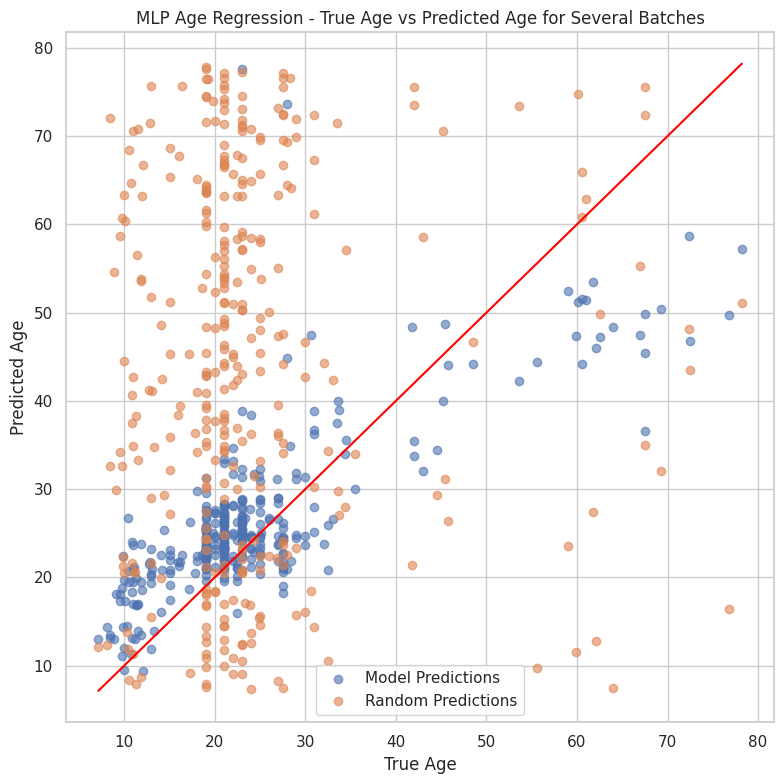

In [ ]:
# Generate random predictions
random_predictions = np.random.uniform(
    low=true_ages_list.min(), high=true_ages_list.max(), size=len(true_ages_list)
)

# Calculate R2 and MSE for random predictions
random_r2_value = r2_score(true_ages_list, random_predictions)
random_mse_value = mean_squared_error(true_ages_list, random_predictions)
print(f"Random Predictions - R2 Score: {random_r2_value:.4f}")
print(f"Random Predictions - Mean Squared Error: {random_mse_value:.4f}")

# Plot the scatter plot for both actual and random predictions
plt.figure(figsize=(8, 8))
plt.scatter(true_ages_list, predicted_ages_list, alpha=0.6, label="Model Predictions")
plt.scatter(true_ages_list, random_predictions, alpha=0.6, label="Random Predictions")
plt.title("MLP Age Regression - True Age vs Predicted Age for Several Batches")
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.plot(
    [min(true_ages_list), max(true_ages_list)],
    [min(true_ages_list), max(true_ages_list)],
    color="red",
)  # Line of best fit
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.3. Baseline: Deep Neural Network Brain Volume Prediction

Now you must define and train your volume prediction model!


🚧 **Exercise 2.1** 🚧

Define the volume prediction model.


In [ ]:
class VolumePredictor(nn.Module):
    def __init__(self, in_shape, out_size):
        super().__init__()

        self.conv1 = nn.Conv3d(in_shape[0], 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(16, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 24 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, out_size)
        self.Leakyrelu = nn.LeakyReLU()

    def forward(self, x):
        x = self.pool(self.Leakyrelu(self.conv1(x)))
        x = self.pool(self.Leakyrelu(self.conv2(x)))
        x = x.view(-1, 64 * 24 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
tmp = next(vol_train_loader.__iter__())
in_shape = tmp["X"].shape[1:]
out_size = tmp["y"].shape[-1]

vol_model = VolumePredictor(in_shape, out_size).float().to(device)
summary(vol_model, (1, 96, 96, 96))

input = tmp["X"].to(device)
output = vol_model(input)
print(output.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 96, 96, 96]           2,016
         LeakyReLU-2       [-1, 16, 96, 96, 96]               0
         MaxPool3d-3       [-1, 16, 48, 48, 48]               0
            Conv3d-4       [-1, 64, 48, 48, 48]          27,712
         LeakyReLU-5       [-1, 64, 48, 48, 48]               0
         MaxPool3d-6       [-1, 64, 24, 24, 24]               0
            Linear-7                  [-1, 128]     113,246,336
            Linear-8                    [-1, 3]             387
Total params: 113,276,451
Trainable params: 113,276,451
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.38
Forward/backward pass size (MB): 344.25
Params size (MB): 432.12
Estimated Total Size (MB): 779.74
----------------------------------------------------------------
torch.Size([8, 3])


#### Train volume prediction model


**Optional Exercise:** Feel free to modify the training loop, training parameters, etc, if there is anything you wish to improve


In [ ]:
# Defining the training parameters
vol_loss_fn = nn.MSELoss()
vol_optimizer = torch.optim.Adam(vol_model.parameters(), lr=1e-3)
epochs = 30

# Training
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(vol_train_loader, vol_model, vol_loss_fn, vol_optimizer)
    test_loss = test(vol_val_loader, vol_model, vol_loss_fn, volume_norm_stats)
print("Done!")

Epoch 1
-------------------------------
Train loss: 76.486617
Test loss: 1.833770, MAE: 76.970683

Epoch 2
-------------------------------
Train loss: 1.169797
Test loss: 1.216526, MAE: 61.381804

Epoch 3
-------------------------------
Train loss: 0.944274
Test loss: 1.134136, MAE: 57.865373

Epoch 4
-------------------------------
Train loss: 0.901958
Test loss: 1.118951, MAE: 57.139747

Epoch 5
-------------------------------
Train loss: 0.859617
Test loss: 1.093378, MAE: 56.300781

Epoch 6
-------------------------------
Train loss: 0.802761
Test loss: 1.044495, MAE: 54.994601

Epoch 7
-------------------------------
Train loss: 0.733168
Test loss: 1.001574, MAE: 54.087322

Epoch 8
-------------------------------
Train loss: 0.640382
Test loss: 0.973765, MAE: 54.418007

Epoch 9
-------------------------------
Train loss: 0.638577
Test loss: 0.880438, MAE: 50.449112

Epoch 10
-------------------------------
Train loss: 0.535299
Test loss: 0.869235, MAE: 50.193667

Epoch 11
---------

Visualize the volume predictions:


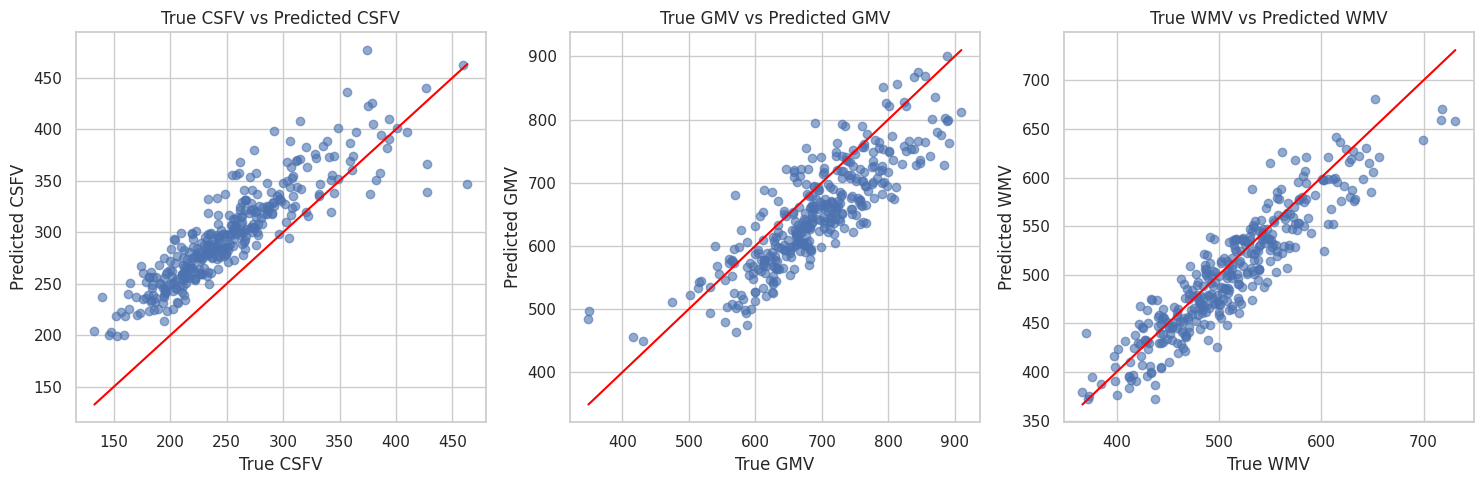

In [ ]:
true_csfv_list = []
predicted_csfv_list = []

true_gmv_list = []
predicted_gmv_list = []

true_wmv_list = []
predicted_wmv_list = []

# Loop through the train loader 🚧 Exercise: Is the train data the best dataset to use to visualize model performance here? 🚧
for batch in vol_train_loader:
    with torch.no_grad():
        inputs = batch["X"].to(device)
        true_volumes = batch["y"].cpu().numpy()

        # Predict volumes
        predicted_volumes = vol_model(inputs).detach().cpu().numpy()

        # Denormalize predicted volumes and true volumes
        predicted_volumes = (
            predicted_volumes * volume_norm_stats["std"] + volume_norm_stats["mean"]
        )
        true_volumes = (
            true_volumes * volume_norm_stats["std"] + volume_norm_stats["mean"]
        )

        # Append true and predicted volumes to the respective lists
        true_csfv_list.extend(true_volumes[:, 0])
        predicted_csfv_list.extend(predicted_volumes[:, 0])

        true_gmv_list.extend(true_volumes[:, 1])
        predicted_gmv_list.extend(predicted_volumes[:, 1])

        true_wmv_list.extend(true_volumes[:, 2])
        predicted_wmv_list.extend(predicted_volumes[:, 2])

# Convert lists to numpy arrays
true_csfv_array = np.array(true_csfv_list)
predicted_csfv_array = np.array(predicted_csfv_list)

true_gmv_array = np.array(true_gmv_list)
predicted_gmv_array = np.array(predicted_gmv_list)

true_wmv_array = np.array(true_wmv_list)
predicted_wmv_array = np.array(predicted_wmv_list)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot true vs predicted volumes for csfv
axes[0].scatter(true_csfv_array, predicted_csfv_array, alpha=0.6)
axes[0].plot(
    [min(true_csfv_array), max(true_csfv_array)],
    [min(true_csfv_array), max(true_csfv_array)],
    color="red",
)
axes[0].set_title("True CSFV vs Predicted CSFV")
axes[0].set_xlabel("True CSFV")
axes[0].set_ylabel("Predicted CSFV")
axes[0].grid(True)

# Plot true vs predicted volumes for gmv
axes[1].scatter(true_gmv_array, predicted_gmv_array, alpha=0.6)
axes[1].plot(
    [min(true_gmv_array), max(true_gmv_array)],
    [min(true_gmv_array), max(true_gmv_array)],
    color="red",
)
axes[1].set_title("True GMV vs Predicted GMV")
axes[1].set_xlabel("True GMV")
axes[1].set_ylabel("Predicted GMV")
axes[1].grid(True)

# Plot true vs predicted volumes for wmv
axes[2].scatter(true_wmv_array, predicted_wmv_array, alpha=0.6)
axes[2].plot(
    [min(true_wmv_array), max(true_wmv_array)],
    [min(true_wmv_array), max(true_wmv_array)],
    color="red",
)
axes[2].set_title("True WMV vs Predicted WMV")
axes[2].set_xlabel("True WMV")
axes[2].set_ylabel("Predicted WMV")
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate R2 and MAE for CSFV
r2_csfv = r2_score(true_csfv_array, predicted_csfv_array)
mae_csfv = mean_absolute_error(true_csfv_array, predicted_csfv_array)

# Calculate R2 and MAE for GMV
r2_gmv = r2_score(true_gmv_array, predicted_gmv_array)
mae_gmv = mean_absolute_error(true_gmv_array, predicted_gmv_array)

# Calculate R2 and MAE for WMV
r2_wmv = r2_score(true_wmv_array, predicted_wmv_array)
mae_wmv = mean_absolute_error(true_wmv_array, predicted_wmv_array)

# Print R2 and MAE for each plot
print(f"CSFV - R2: {r2_csfv:.4f}, MAE: {mae_csfv:.4f}")
print(f"GMV - R2: {r2_gmv:.4f}, MAE: {mae_gmv:.4f}")
print(f"WMV - R2: {r2_wmv:.4f}, MAE: {mae_wmv:.4f}")


CSFV - R2: 0.1937, MAE: 47.1160
GMV - R2: 0.5011, MAE: 53.2610
WMV - R2: 0.8206, MAE: 21.5989


### 2.4. Baseline: Combine models to attain end-to-end predictions

Finally, we will combine the deep learning volume prediction model with the MLP regression model to obtain end-to-end predictions of age from MRI images.


Define the end-to-end validation dataset and data loaders:


In [ ]:
class EndToEndDataset(Dataset):
    def __init__(
        self,
        patient_list: List[str],
        mri_file_dir: str,
        meta_df: pd.DataFrame,
        ages_norm_stats: Dict[str, np.array],
        out_spacing=OUT_SPACING,
        out_size=OUT_SIZE,
    ):
        self.samples: List[Dict[str, torch.tensor]] = []

        for pat in tqdm(patient_list, desc="Loading Data"):
            # MRI images
            X = load_patient_mri_array(pat, mri_dir=mri_file_dir).squeeze()
            X = zero_mean_unit_var(X)
            if (out_spacing is not None) and (out_size is not None):
                X = resample_image(X, out_spacing=out_spacing, out_size=out_size)
            X = torch.from_numpy(X).unsqueeze(0).float()

            # Ages
            y = meta_df[meta_df["participant_id"] == pat][["age"]].values.squeeze()
            y = (y - ages_norm_stats["mean"]) / ages_norm_stats["std"]
            y = torch.tensor(y).unsqueeze(0).float()

            sample = {"X": X, "y": y}
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item]


In [ ]:
# Expect this cell to take 8 mins

batch_size = 8  # Can be changed if you wish

# Training
train_data_h2 = VolumePredictionDataset(
    patient_list=train_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
)
vol_train_loader = DataLoader(vol_train_data, batch_size=batch_size)

# Validation
vol_val_data = VolumePredictionDataset(
    patient_list=val_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
)
vol_val_loader = DataLoader(vol_val_data, batch_size=batch_size)

# Testing
vol_test_data = VolumePredictionDataset(
    patient_list=test_pats,
    mri_file_dir=TEST_MRI_DIR,
    meta_df=test_meta_df,
    volume_norm_stats=volume_norm_stats,
)

# Check the number of batches in each DataLoader
num_batches_train = len(vol_train_loader)
num_batches_val = len(vol_val_loader)
num_batches_test = len(DataLoader(vol_test_data, batch_size=batch_size))

print(f"Number of batches in training DataLoader: {num_batches_train}")
print(f"Number of batches in validation DataLoader: {num_batches_val}")
print(f"Number of batches in testing DataLoader: {num_batches_test}")

# Check the output of the dataloader
tmp = next(vol_train_loader.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (MRI images) dimensions are: {tmp['X'].shape}")
print(f"The output (csfv, gmv, wmv brain volumes) dimensions are: {tmp['y'].shape}")

Loading Data: 100%|██████████| 167/167 [01:39<00:00,  1.67it/s]

Number of batches in training DataLoader: 44
Number of batches in validation DataLoader: 15
Number of batches in testing DataLoader: 21
Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input (MRI images) dimensions are: torch.Size([8, 1, 96, 96, 96])
The output (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([8, 3])


In [ ]:
e2e_val_data = EndToEndDataset(
    patient_list=val_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    ages_norm_stats=ages_norm_stats,
)
e2e_val_loader = DataLoader(e2e_val_data, batch_size=2)

tmp = next(e2e_val_loader.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input dimensions are: {tmp['X'].shape}")
print(f"The output dimensions are: {tmp['y'].shape}")

Loading Data: 100%|██████████| 115/115 [01:07<00:00,  1.71it/s]

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input dimensions are: torch.Size([2, 1, 96, 96, 96])
The output dimensions are: torch.Size([2, 1])


Define the combined model:


In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, volume_predictor, age_regressor):
        super(CombinedModel, self).__init__()
        self.volume_predictor = volume_predictor
        self.age_regressor = age_regressor

    def forward(self, x):
        x = self.volume_predictor(x)
        return self.age_regressor(x)

In [ ]:
combined_model = CombinedModel(vol_model, mlp_model).float().to(device)

tmp = next(e2e_val_loader.__iter__())
output = combined_model(tmp["X"].to(device))

Assess performance of end-to-end model on the validation data:


In [ ]:
e2e_loss_fn = nn.MSELoss()
test(e2e_val_loader, combined_model, e2e_loss_fn, ages_norm_stats)

Test loss: 0.994954, MAE: 11.366888



R2 Score: 0.3095
Mean Squared Error: 171.4615


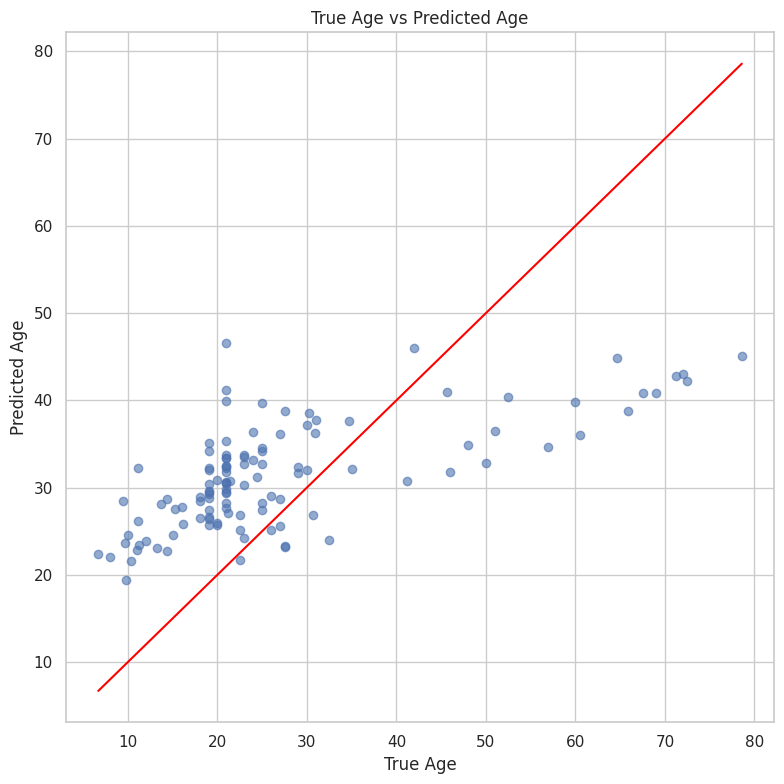

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

true_ages_list = []
predicted_ages_list = []

# Loop through the loader for a certain number of batches of the validation data
for i, batch in enumerate(e2e_val_loader):
    with torch.no_grad():
        inputs = batch["X"].to(device)
        true_ages = batch["y"].cpu().numpy().reshape(-1)
        predicted_ages = combined_model(inputs).detach().cpu().numpy().reshape(-1)
    true_ages_list.extend(true_ages)
    predicted_ages_list.extend(predicted_ages)

# Denormalize the true ages
true_ages_list = (
    np.array(true_ages_list) * ages_norm_stats["std"] + ages_norm_stats["mean"]
)
predicted_ages_list = (
    np.array(predicted_ages_list) * ages_norm_stats["std"] + ages_norm_stats["mean"]
)

# Calculate R2 and MSE
r2_value = r2_score(true_ages_list, predicted_ages_list)
mse_value = mean_squared_error(true_ages_list, predicted_ages_list)
print(f"R2 Score: {r2_value:.4f}")
print(f"Mean Squared Error: {mse_value:.4f}")

# Plot the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(true_ages_list, predicted_ages_list, alpha=0.6)
plt.title("True Age vs Predicted Age")
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.plot(
    [min(true_ages_list), max(true_ages_list)],
    [min(true_ages_list), max(true_ages_list)],
    color="red",
)  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

#### 🚧 **Exercise 2.2** 🚧


Analyse you results and consider writting about the following in your report:

- Justification for your volume prediction model structure/design
- Discussion of results from volume prediction model
- Discussion of results from the MLP regression model
- Discusion of results from end-to-end combined model
- Discussion of reasonability of performance (and what the limitations may be and why)

You should provide evidence to backup your discussions and any conclusions. This may include showing performance on held out validation/test sets (using the metrics you chose previously), and other statistical tests or visualisations. You do not have to limit yourself to the visualisations/analysis already implemented in the notebook!


<Insert report here>


## Part 3: Improving upon the Baseline

Here you should make three meaningful attempts to improve upon the baseline model.

Start by analysing the performance of the baseline model and propose a hypothesis for where the model could be improved. The hypothesis could align to one of:

- Architecture: Would a different NN architecture be better? Maybe try training a deep learning model end to end, rather than first predicting volumes then predicting age.
- Hyperparameters: Is the learning rate set correctly? Should early stopping or other kinds of regularizations be used?
- Auxiliary losses: Can you use the extra information in the training data to provide richer training signals to the model?
- Data augmentation: Can simple augmentations improve performance? (This can be especially helpful when the dataset is small!)
- Skewed dataset: Are there techniques that can be used to account for the negative effects of a skewed/imbalanced dataset?

Now implement a new model based on your hypothesis!

Iterate though this procedure until you have proposed 3 hypotheses and developed 3 models.

Don’t worry if an experiment does not produce the intended results - write about why you think it didn’t produce those results! Note, that since this is deep learning, there may not always be an obvious explanation - in these cases so long as your initial hypothesis was valid and you have made attempts to find an explanation (where possible) you will not lose marks.

If you feel a set of experiments are leading you down a dead end - don’t worry! Write about why you feel that line of enquiry is not working, take a few steps back (even if that means going back to the baseline model) and start again for your next hypothesis. Failed experiments often yield interesting and insightful results!

**Further guidelines for the hypotheses:**

- Scope: Ensure your hypothesis is not too limited in scope. For example, simply changing the learning rate value once would be insufficient. Instead, you could try a sweep over learning rates.
- Grounded reasoning: Your reasoning and justifications should be grounded in what you have learned in the course materials/lectures/tutorials.
- Evidence-backed conclusions: If you are making conclusions, ensure to present suitably strong evidence. If there is not enough evidence to make a strong conclusion, ensure you acknowledge this.

**Marking:**

In the report, marks will primarily be awarded for:

- The quality of your hypotheses, and their justifications (including how you move from one hypothesis/experiment to the next)
- The quality/thoroughness of the experiments you run to test your hypotheses, and your presentation and discussion of the results

You will **not** be marked on the overall performance of your model. This coursework is designed to test your ability to propose reasonable experiments and to test your understanding of the content of the course.


In [ ]:
# First data filtration
## Training data
train_meta_df_h = train_meta_df.drop(
    ["diagnosis", "study", "site", "age_round", "age_10_yr_bckt"], axis=1
)
train_meta_df_h = train_meta_df_h[train_meta_df_h["magnetic_field_strength"] == 3]
## Testing data
test_meta_df_h = test_meta_df.drop(
    ["diagnosis", "study", "site", "age_round", "age_10_yr_bckt"], axis=1
)
test_meta_df_h = test_meta_df_h[test_meta_df_h["magnetic_field_strength"] == 3]

## 🚧 Exercise 3.1: Training both models together 🚧

The MLP and the VolumePrediction models are trained separately and then ran together in the End-to-End model. The purpose of this hypothesis is to train both models together.


In [ ]:
##########################################
# Test Hypothesis 1: Training both models together
##########################################

### 3.2.a Data preprocessing


In [ ]:
# Defining the dataframes
train_meta_df_h1 = train_meta_df.copy()
test_meta_df_h1 = test_meta_df.copy()

In [ ]:
# Normalization stats
ages_norm_stats_h1 = {
    "mean": train_meta_df_h1["age"].mean(axis=0),
    "std": train_meta_df_h1["age"].std(axis=0),
}
volume_norm_stats_h1 = {
    "mean": train_meta_df_h1[["csfv", "gmv", "wmv"]].mean(axis=0).values,
    "std": train_meta_df_h1[["csfv", "gmv", "wmv"]].std(axis=0).values,
}

display(ages_norm_stats_h1)
display(volume_norm_stats_h1)

{'mean': 24.730252048494517, 'std': 13.336105435557256}

{'mean': array([253.44248979, 688.5824933 , 513.71863709]),
 'std': array([58.58350478, 88.89055568, 65.53866211])}

In [ ]:
# Defining Datasets and Dataloaders

## Batch size
batch_size_h1 = 9

## Training
train_data_h1 = EndToEndDataset(
    patient_list=train_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df_h1,
    ages_norm_stats=ages_norm_stats_h1,
)
train_loader_h1 = DataLoader(train_data_h1, batch_size=batch_size_h1)

## Validation
val_data_h1 = EndToEndDataset(
    patient_list=val_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df_h1,
    ages_norm_stats=ages_norm_stats_h1,
)
val_loader_h1 = DataLoader(val_data_h1, batch_size=batch_size_h1)

## Testing
test_data_h1 = EndToEndDataset(
    patient_list=test_pats,
    mri_file_dir=TEST_MRI_DIR,
    meta_df=test_meta_df_h1,
    ages_norm_stats=ages_norm_stats_h1,
)


## Check the number of batches in each DataLoader
num_batches_train_h1 = len(train_loader_h1)
num_batches_val_h1 = len(val_loader_h1)
num_batches_test_h1 = len(DataLoader(test_data_h1, batch_size=batch_size_h1))

print(f"Number of batches in training DataLoader: {num_batches_train_h1}")
print(f"Number of batches in validation DataLoader: {num_batches_val_h1}")
print(f"Number of batches in testing DataLoader: {num_batches_test_h1}")


# Check the output of the dataloader
tmp = next(train_loader_h1.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (MRI images) dimensions are: {tmp['X'].shape}")
print(f"The output (csfv, gmv, wmv brain volumes) dimensions are: {tmp['y'].shape}")

Loading Data: 100%|██████████| 167/167 [01:42<00:00,  1.63it/s]

Number of batches in training DataLoader: 39
Number of batches in validation DataLoader: 13
Number of batches in testing DataLoader: 19
Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input (MRI images) dimensions are: torch.Size([9, 1, 96, 96, 96])
The output (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([9, 1])


### 3.2.b Model definition


In [ ]:
model_h1 = CombinedModel(vol_model, mlp_model).float().to(device)

tmp = next(val_loader_h1.__iter__())
output = model_h1(tmp["X"].to(device))
print("Combined Model output shape: ", output.shape)

Combined Model output shape:  torch.Size([9, 1])


In [ ]:
def check_data_size(loader, name):
    sizes = set()
    for i, data in enumerate(loader):
        sizes.add(data["X"].shape)

    if len(sizes) == 1:
        print(f"All data in {name} have the same size: {sizes.pop()}")
    else:
        print(f"Not all data in {name} have the same size. Sizes: {sizes}")

# Check train_loader_h1
try:
    check_data_size(train_loader_h1, "train_loader_h1")
except RuntimeError as e:
    print(f"Error checking train_loader_h1: {e}")

# Check val_loader_h1
try:
    check_data_size(val_loader_h1, "val_loader_h1")
except RuntimeError as e:
    print(f"Error checking val_loader_h1: {e}")


All data in train_loader_h1 have the same size: torch.Size([9, 1, 96, 96, 96])
Not all data in val_loader_h1 have the same size. Sizes: {torch.Size([9, 1, 96, 96, 96]), torch.Size([7, 1, 96, 96, 96])}


In [ ]:
loss_fn_h1 = nn.MSELoss()
optimizer_h1 = torch.optim.Adam(model_h1.parameters(), lr=1e-3)

epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader_h1, model_h1, loss_fn_h1, optimizer_h1)
    test(val_loader_h1, model_h1, loss_fn_h1, volume_norm_stats_h1)
print("Done!")

Epoch 1
-------------------------------
Train loss: 0.692784
Test loss: 1.735177, MAE: 79.141130

Epoch 2
-------------------------------
Train loss: 0.556880
Test loss: 27.545116, MAE: 360.827444

Epoch 3
-------------------------------
Train loss: 2.127741
Test loss: 3.925011, MAE: 132.627953

Epoch 4
-------------------------------
Train loss: 33.807729
Test loss: 3.201661, MAE: 92.270932

Epoch 5
-------------------------------
Train loss: 0.275688
Test loss: 17.350744, MAE: 282.129582

Epoch 6
-------------------------------
Train loss: 2.393098
Test loss: 2.010555, MAE: 91.281621

Epoch 7
-------------------------------
Train loss: 1.507856
Test loss: 1.705660, MAE: 56.575536

Epoch 8
-------------------------------
Train loss: 0.851451
Test loss: 1.698389, MAE: 56.496887

Epoch 9
-------------------------------
Train loss: 0.846380
Test loss: 1.690727, MAE: 56.501496

Epoch 10
-------------------------------
Train loss: 0.809540
Test loss: 1.607379, MAE: 76.150546

Epoch 11
----

In [ ]:
test(val_loader_h1, model_h1, loss_fn_h1, ages_norm_stats_h1)

Test loss: 1.654486, MAE: 10.917821



R2 Score: -0.0518
Mean Squared Error: 261.1882


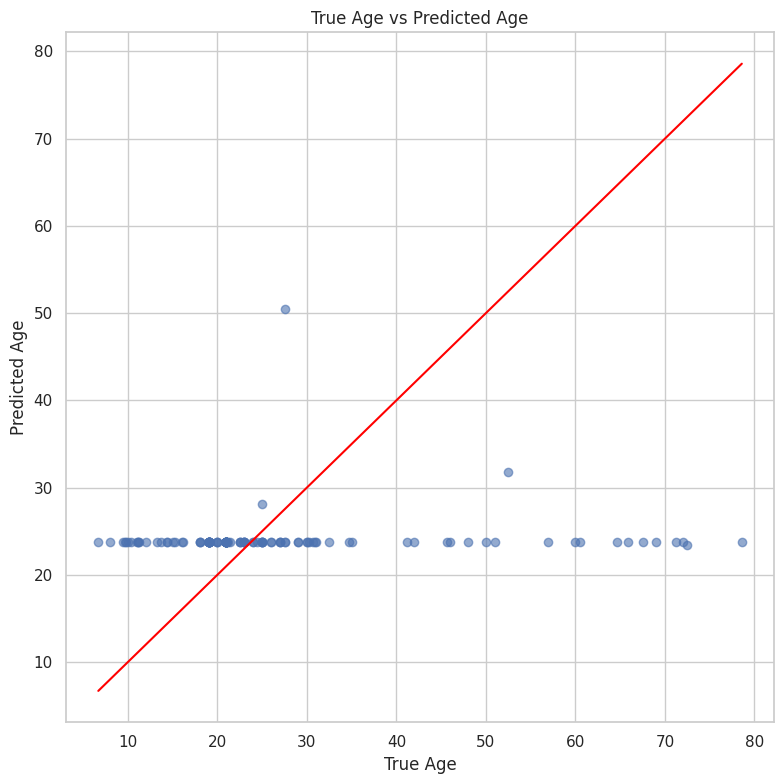

In [ ]:
true_ages_list = []
predicted_ages_list = []

# Loop through the loader for a certain number of batches of the validation data
for i, batch in enumerate(val_loader_h1):
    with torch.no_grad():
        inputs = batch["X"].to(device)
        true_ages = batch["y"].cpu().numpy().reshape(-1)
        predicted_ages = model_h1(inputs).detach().cpu().numpy().reshape(-1)
    true_ages_list.extend(true_ages)
    predicted_ages_list.extend(predicted_ages)

# Denormalize the true ages
true_ages_list = (
    np.array(true_ages_list) * ages_norm_stats_h1["std"] + ages_norm_stats_h1["mean"]
)
predicted_ages_list = (
    np.array(predicted_ages_list) * ages_norm_stats_h1["std"] + ages_norm_stats_h1["mean"]
)

# Calculate R2 and MSE
r2_value = r2_score(true_ages_list, predicted_ages_list)
mse_value = mean_squared_error(true_ages_list, predicted_ages_list)
print(f"R2 Score: {r2_value:.4f}")
print(f"Mean Squared Error: {mse_value:.4f}")

# Plot the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(true_ages_list, predicted_ages_list, alpha=0.6)
plt.title("True Age vs Predicted Age")
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.plot(
    [min(true_ages_list), max(true_ages_list)],
    [min(true_ages_list), max(true_ages_list)],
    color="red",
)  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

Training the CombinedModel on its' own didn't end with clear results, as it does't involve training both models together. We try to train both models together, this means redefining volume predictions:

### 3.2.c Model correction

In [1]:
# Defining a combined dataset and not an endtoend dataset:

class CombinedDataset(Dataset):
    def __init__(
        self,
        patient_list: List[str],
        mri_file_dir: str,
        meta_df: pd.DataFrame,
        volume_norm_stats: Dict[str, np.array],
        ages_norm_stats: Dict[str, np.array],
        out_spacing=OUT_SPACING,
        out_size=OUT_SIZE,
    ):
        self.samples: List[Dict[str, torch.tensor]] = []

        for pat in tqdm(patient_list, desc="Loading Data"):
            # MRI image
            X_mri = load_patient_mri_array(pat, mri_dir=mri_file_dir).squeeze()
            X_mri = zero_mean_unit_var(X_mri)
            if (out_spacing is not None) and (out_size is not None):
                X_mri = resample_image(X_mri, out_spacing=out_spacing, out_size=out_size)
            X_mri = torch.from_numpy(X_mri).unsqueeze(0).float()

            # Volume labels
            y_volume = meta_df[meta_df["participant_id"] == pat][
                ["csfv", "gmv", "wmv"]
            ].values.squeeze()
            y_volume = (y_volume - volume_norm_stats["mean"]) / volume_norm_stats["std"]
            y_volume = torch.from_numpy(y_volume).float()

            # Ages
            y_age = meta_df[meta_df["participant_id"] == pat][["age"]].values.squeeze()
            y_age = (y_age - ages_norm_stats["mean"]) / ages_norm_stats["std"]
            y_age = torch.tensor(y_age).float()

            sample = {"X_mri": X_mri, "y_volume": y_volume, "y_age": y_age}
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item]

NameError: ignored

In [ ]:
# RE Defining the dataloaders

## Batch size
batch_size_h1 = 9

## Training
train_data_h1 = CombinedDataset(
    patient_list=train_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df_h1,
    volume_norm_stats=volume_norm_stats_h1,
    ages_norm_stats=ages_norm_stats_h1,
)
train_loader_h1 = DataLoader(train_data_h1, batch_size=batch_size_h1)

## Validation
val_data_h1 = CombinedDataset(
    patient_list=val_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df_h1,
    volume_norm_stats=volume_norm_stats_h1,
    ages_norm_stats=ages_norm_stats_h1,
)
val_loader_h1 = DataLoader(val_data_h1, batch_size=batch_size_h1)

## Testing
test_data_h1 = CombinedDataset(
    patient_list=test_pats,
    mri_file_dir=TEST_MRI_DIR,
    meta_df=test_meta_df_h1,
    volume_norm_stats=volume_norm_stats_h1,
    ages_norm_stats=ages_norm_stats_h1,
)

## Check the number of batches in each DataLoader
num_batches_train_h1 = len(train_loader_h1)
num_batches_val_h1 = len(val_loader_h1)
num_batches_test_h1 = len(DataLoader(test_data_h1, batch_size=batch_size_h1))

print(f"Number of batches in training DataLoader: {num_batches_train_h1}")
print(f"Number of batches in validation DataLoader: {num_batches_val_h1}")
print(f"Number of batches in testing DataLoader: {num_batches_test_h1}")


# Check the output of the dataloader
tmp = next(train_loader_h1.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (MRI images) dimensions are: {tmp['X_mri'].shape}")
print(f"The input (MRI images) dimensions are: {tmp['X_mri'].shape}")
print(f"The volume (csfv, gmv, wmv brain volumes) dimensions are: {tmp['y_volume'].shape}")
print(f"The output (age) dimensions are: {tmp['y_age'].shape}")

Loading Data: 100%|██████████| 167/167 [01:34<00:00,  1.77it/s]

Number of batches in training DataLoader: 39
Number of batches in validation DataLoader: 13
Number of batches in testing DataLoader: 19
Dataloader has output type <class 'dict'> with keys dict_keys(['X_mri', 'y_volume', 'y_age'])
The input (MRI images) dimensions are: torch.Size([9, 1, 96, 96, 96])
The input (MRI images) dimensions are: torch.Size([9, 1, 96, 96, 96])
The volume (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([9, 3])
The output (age) dimensions are: torch.Size([9])


In [ ]:
# Check the output of the dataloader
tmp = next(train_loader_h1.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (MRI images) dimensions are: {tmp['X_mri'].shape}")
print(f"The input (MRI images) dimensions are: {tmp['X_mri'].shape}")
print(f"The volume (csfv, gmv, wmv brain volumes) dimensions are: {tmp['y_volume'].shape}")
print(f"The output (age) dimensions are: {tmp['y_age'].shape}")

Dataloader has output type <class 'dict'> with keys dict_keys(['X_mri', 'y_volume', 'y_age'])
The input (MRI images) dimensions are: torch.Size([9, 1, 96, 96, 96])
The input (MRI images) dimensions are: torch.Size([9, 1, 96, 96, 96])
The volume (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([9, 3])
The output (age) dimensions are: torch.Size([9])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define your loss functions
volume_loss_fn = nn.MSELoss()
age_loss_fn = nn.MSELoss()

# Define weights for the combined loss
age_weight = 0.8
volume_weight = 1 - age_weight

# Ridge regularization strength
ridge_alpha = 0.01

# Define your optimizer for the combined model
combined_optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.001)

# Training loop
epochs = 30
for epoch in range(epochs):
    for batch in train_loader_h1:
        inputs_mri = batch['X_mri']
        targets_volume = batch['y_volume']
        targets_age = batch['y_age']

        # Move data to the same device as the model
        inputs_mri = inputs_mri.to(device)
        targets_volume = targets_volume.to(device)
        targets_age = targets_age.to(device)

        # Zero the gradients for the optimizer
        combined_optimizer.zero_grad()

        # Forward pass through the combined model
        outputs_volume = combined_model.volume_predictor(inputs_mri)
        outputs_age = combined_model.age_regressor(outputs_volume)

        # Compute the loss for each task
        volume_loss = volume_loss_fn(outputs_volume, targets_volume)

        # Add ridge regularization term to volume loss
        volume_loss += ridge_alpha * sum(torch.sum(p**2) for p in combined_model.volume_predictor.parameters())

        age_loss = age_loss_fn(outputs_age.squeeze(), targets_age)

        # Add ridge regularization term to age loss
        age_loss += ridge_alpha * sum(torch.sum(p**2) for p in combined_model.age_regressor.parameters())

        # Combine the losses with weights
        combined_loss = volume_weight * volume_loss + age_weight * age_loss

        # Backward pass and update
        combined_loss.backward()
        combined_optimizer.step()
        combined_optimizer.zero_grad()

    print(f'Epoch [{epoch+1}/{epochs}], Combined Loss: {combined_loss.item()}')

print("Done!")

Epoch [1/30], Combined Loss: 6.757107257843018
Epoch [2/30], Combined Loss: 2.939070701599121
Epoch [3/30], Combined Loss: 3.409564256668091
Epoch [4/30], Combined Loss: 4.7914581298828125
Epoch [5/30], Combined Loss: 4.645500659942627
Epoch [6/30], Combined Loss: 5.885499000549316
Epoch [7/30], Combined Loss: 5.72233772277832
Epoch [8/30], Combined Loss: 9.365107536315918
Epoch [9/30], Combined Loss: 10.50498104095459
Epoch [10/30], Combined Loss: 10.49795913696289
Epoch [11/30], Combined Loss: 10.1832857131958
Epoch [12/30], Combined Loss: 10.0609130859375
Epoch [13/30], Combined Loss: 9.952735900878906
Epoch [14/30], Combined Loss: 9.971626281738281
Epoch [15/30], Combined Loss: 9.868937492370605
Epoch [16/30], Combined Loss: 9.803112983703613
Epoch [17/30], Combined Loss: 9.756494522094727
Epoch [18/30], Combined Loss: 9.723803520202637
Epoch [19/30], Combined Loss: 9.75953197479248
Epoch [20/30], Combined Loss: 9.63497543334961
Epoch [21/30], Combined Loss: 9.568442344665527
Epoch

In [ ]:
# Place this at the beginning of your code
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

R2 Score: 0.0212
Mean Squared Error: 243.0544


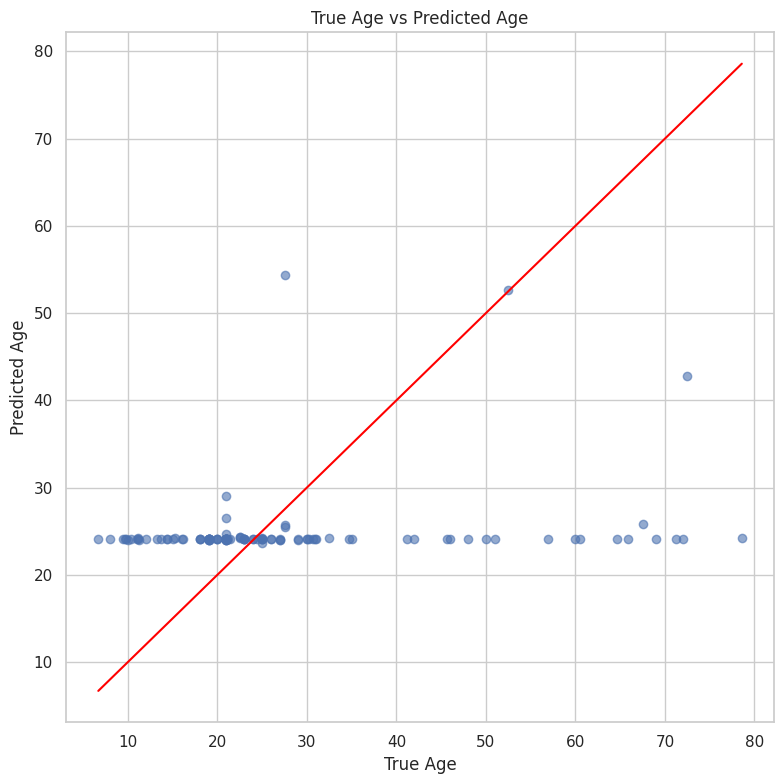

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

true_ages_list = []
predicted_ages_list = []

# Loop through the loader for a certain number of batches of the validation data
for i, batch in enumerate(val_loader_h1):
    with torch.no_grad():
        inputs = batch["X_mri"].to(device)
        true_ages = batch["y_age"].cpu().numpy().reshape(-1)
        predicted_ages = combined_model.age_regressor(combined_model.volume_predictor(inputs)).detach().cpu().numpy().reshape(-1)
    true_ages_list.extend(true_ages)
    predicted_ages_list.extend(predicted_ages)

# Denormalize the true ages
true_ages_list = (
    np.array(true_ages_list) * ages_norm_stats_h1["std"] + ages_norm_stats_h1["mean"]
)
predicted_ages_list = (
    np.array(predicted_ages_list) * ages_norm_stats_h1["std"] + ages_norm_stats_h1["mean"]
)

# Calculate R2 and MSE
r2_value = r2_score(true_ages_list, predicted_ages_list)
mse_value = mean_squared_error(true_ages_list, predicted_ages_list)
print(f"R2 Score: {r2_value:.4f}")
print(f"Mean Squared Error: {mse_value:.4f}")

# Plot the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(true_ages_list, predicted_ages_list, alpha=0.6)
plt.title("True Age vs Predicted Age")
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.plot(
    [min(true_ages_list), max(true_ages_list)],
    [min(true_ages_list), max(true_ages_list)],
    color="red",
)  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

## 🚧 Exercise 3.2: ResNet EndToEnd architecture 🚧


When detailing your Hypothesis 1-3 in the report, some points to touch on include:

- Explain your hypothesis and the reasoning behind it (e.g. why do you think this could improve performance, how does it relate to your previous experiment).
- How do you intend to test the hypothesis (i.e. what experiments will you run)?
- What evidence is required to confirm/disprove the hypothesis?
- What do you hope to learn from your experiments?


In [ ]:
# #######################################
# Test Hypothesis 2: End-to-End architecture with ResNet

# Feel free to use as many cells as necessary
# #######################################

### Data preprocessing and setup


In [ ]:
train_meta_df_h2 = train_meta_df_h.copy()
test_meta_df_h2 = test_meta_df_h.copy()

In [ ]:
# Normalization stats
ages_norm_stats_h2 = {
    "mean": train_meta_df_h2["age"].mean(axis=0),
    "std": train_meta_df_h2["age"].std(axis=0),
}

volume_norm_stats_h2 = {
    "mean": train_meta_df_h2[["csfv", "gmv", "wmv"]].mean(axis=0).values,
    "std": train_meta_df_h2[["csfv", "gmv", "wmv"]].std(axis=0).values,
}

display(ages_norm_stats_h2)
display(volume_norm_stats_h2)

{'mean': 23.554116875348136, 'std': 11.941334414668962}

{'mean': array([250.4603117 , 692.47373885, 511.77359096]),
 'std': array([57.18522026, 86.8357618 , 63.74895132])}

In [ ]:
# Defining Datasets and Dataloaders

## Batch size
batch_size_h2 = 2 # Smaller batch size is better for GPU

## Training
train_data_h2 = EndToEndDataset(
    patient_list=train_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df_h2,
    ages_norm_stats=ages_norm_stats_h2,
)
train_loader_h2 = DataLoader(train_data_h2, batch_size=batch_size_h2)

## Validation
val_data_h2 = EndToEndDataset(
    patient_list=val_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df_h2,
    ages_norm_stats=ages_norm_stats_h2,
)
val_loader_h2 = DataLoader(val_data_h2, batch_size=batch_size_h2)

## Testing
test_data_h2 = EndToEndDataset(
    patient_list=test_pats,
    mri_file_dir=TEST_MRI_DIR,
    meta_df=test_meta_df_h2,
    ages_norm_stats=ages_norm_stats_h2,
)


## Check the number of batches in each DataLoader
num_batches_train_h2 = len(train_loader_h2)
num_batches_val_h2 = len(val_loader_h2)
num_batches_test_h2 = len(DataLoader(test_data_h2, batch_size=batch_size))

print(f"Number of batches in training DataLoader: {num_batches_train_h2}")
print(f"Number of batches in validation DataLoader: {num_batches_val_h2}")
print(f"Number of batches in testing DataLoader: {num_batches_test_h2}")


# Check the output of the dataloader
tmp = next(train_loader_h2.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (MRI images) dimensions are: {tmp['X'].shape}")
print(f"The output (csfv, gmv, wmv brain volumes) dimensions are: {tmp['y'].shape}")


In [ ]:
# Define the 3D ResNet architecture
class ResNet3D(nn.Module):
    def __init__(self):
        super(ResNet3D, self).__init__()

        # Define the layers (you can modify the number of layers, filters, etc.)
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.residual_blocks = self._make_residual_blocks()
        self.avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(64, 3)  # Adjust output dimensions based on your task

    def _make_residual_blocks(self):
        # Define the residual blocks
        # This is a simple example; you may need to customize based on your needs
        blocks = []
        for _ in range(3):  # Adjust the number of blocks
            blocks += [ResidualBlock(64, 64)]  # Adjust channels if needed
        return nn.Sequential(*blocks)

    def forward(self, x):
        # Define the forward pass
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.residual_blocks(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Define a basic residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1
        )
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1
        )
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Adjust dimensions if the stride is greater than 1
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm3d(out_channels),
            )

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += self.shortcut(residual)
        x = self.relu(x)
        return x


# Create an instance of the ResNet3D model
resnet_3d_model = ResNet3D()

# Print the model architecture
print(resnet_3d_model)
# summary(resnet_3d_model,(1,96,96,96))

In [ ]:
loss_fn_h2 = nn.MSELoss()
optimizer_h2 = torch.optim.Adam(resnet_3d_model.parameters(), lr=1e-3)

In [ ]:
# Assuming tmp["X"] is the input tensor
input_data = tmp["X"].to(device)
resnet_3d_model.to(device)  # Move the entire model to the GPU

# Forward pass
output = resnet_3d_model(input_data)

# Move the model back to the CPU if needed
resnet_3d_model.to(device)

In [ ]:
# Assuming your ResNet model is in a separate module
# TODO: TEST
# ! ne pas run
tmp = next(train_loader_h2.__iter__())
in_shape = tmp["X"].shape[1:]
# ResNet_model = ResNet18().float().to(device)
output = resnet_3d_model(tmp["X"].to(device))
print("ResNet Model output shape: ", output.shape)

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader_h2, resnet_3d_model, loss_fn_h2, optimizer_h2)
    test(val_loader_h2, resnet_3d_model, loss_fn_h2, ages_norm_stats_h2)
print("Done!")

In [ ]:
true_ages_list_h2 = []
predicted_ages_list_h2 = []

# Loop through the loader for a certain number of batches of the validation data (e.g., 10 batches in this example)
for i, batch in enumerate(train_loader_h2):
    with torch.no_grad():
        inputs_h2 = batch["X"].to(device)
        true_ages_h2 = batch["y"].cpu().numpy().reshape(-1)
        predicted_ages_h2 = ResNet_model(inputs).detach().cpu().numpy().reshape(-1)
    true_ages_list_h2.extend(true_ages_h2)
    predicted_ages_list_h2.extend(predicted_ages_h2)

# denormalize the true ages
true_ages_list_h2 = (
    np.array(true_ages_list_h2) * ages_norm_stats_h2["std"] + ages_norm_stats_h2["mean"]
)
predicted_ages_list_h2 = (
    np.array(predicted_ages_list_h2) * ages_norm_stats_h2["std"]
    + ages_norm_stats_h2["mean"]
)

plt.figure(figsize=(8, 8))
plt.scatter(true_ages_list_h2, predicted_ages_list_h2, alpha=0.6)
plt.title("True Age vs Predicted Age")
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.plot(
    [min(true_ages_list_h2), max(true_ages_list_h2)],
    [min(true_ages_list_h2), max(true_ages_list_h2)],
    color="red",
)  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()


When discussing the results of your hypothesis 1-3 experiments, some points to touch on include:

- Are the results as expected?
- How strong are the conclusions you can draw, based on the evidence you have collected?
- Any interesting findings or potential interesting followup experiments.


## 🚧 Exercise 3.3: Hypothesis 3 🚧


In [ ]:
##########################################
# Test Hypothesis 3: DATA FILTRATION
##########################################


This model delebirately choses to target a younger population, meaning patients below 40 years old, in order to maximise accuracy. It first proceeds by filtering the whole dataset, then runs the model for it all, then for men and women.


In [ ]:
# Run the model for the whole filtered dataset
# Code for running the model on the whole filtered dataset goes here


In [ ]:
# Run the model for women ionly
# Code for running the model on the women subset goes here


In [ ]:
# Run the model for men only
# Code for running the model on the men subset goes here


## HYPOTHESIS 4: ALL HYPOTHESES TOGETHER


## 🚧 Exercise 3.4: Concluding Discussion 🚧

Now you should have trained and validated 4 models (the baseline, and your 3 hypotheses). Below, you should do a final comparison of performances of the models **using the test data!**. This should be the **first and only time** you use the test data!

In your report, you should discuss potential reasons for differences in performance between all 4 models, and conclude which model is best (if any)


In [ ]:
################################################
# INSERT CODE HERE
################################################
